# **Individual Survey Report**

## **Importing**

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.preprocessing import Normalizer
import geopandas as gpd

# set high dpi for better quality
plt.rcParams["figure.dpi"] = 300

In [366]:
# setting the colour of the spines and the face/background
# will be used throughout code so i placed at top
def colours(scheme):
    if scheme == 1:
        ax.set_facecolor('aliceblue')
        ax.spines['top'].set_color('lightblue') 
        ax.spines['right'].set_color('lightblue')
        ax.spines['bottom'].set_color('steelblue')
        ax.spines['left'].set_color('steelblue')

In [436]:
# setting and shortening y ticks, 100000 --> 100K
# will be used throughout code so i placed at top
def ytick_k(ax_in, num):
    f = '{:,.1f}' if num==1 else '{:,.0f}'
    vals = ax_in.get_yticks()
    ax_in.yaxis.set_major_locator(mticker.FixedLocator(vals))
    ax_in.set_yticklabels([f.format(x/1000) + 'K' if x>0 else '0' for x in vals])

In [564]:
# will be used throughout code so i placed at top
# setting the title and labels
def ax_title_xy(_ax, title, x, y):
    _ax.set_title( title, fontsize = 16)
    _ax.set_ylabel(y, fontsize = 14)
    _ax.set_xlabel(x, fontsize = 14)

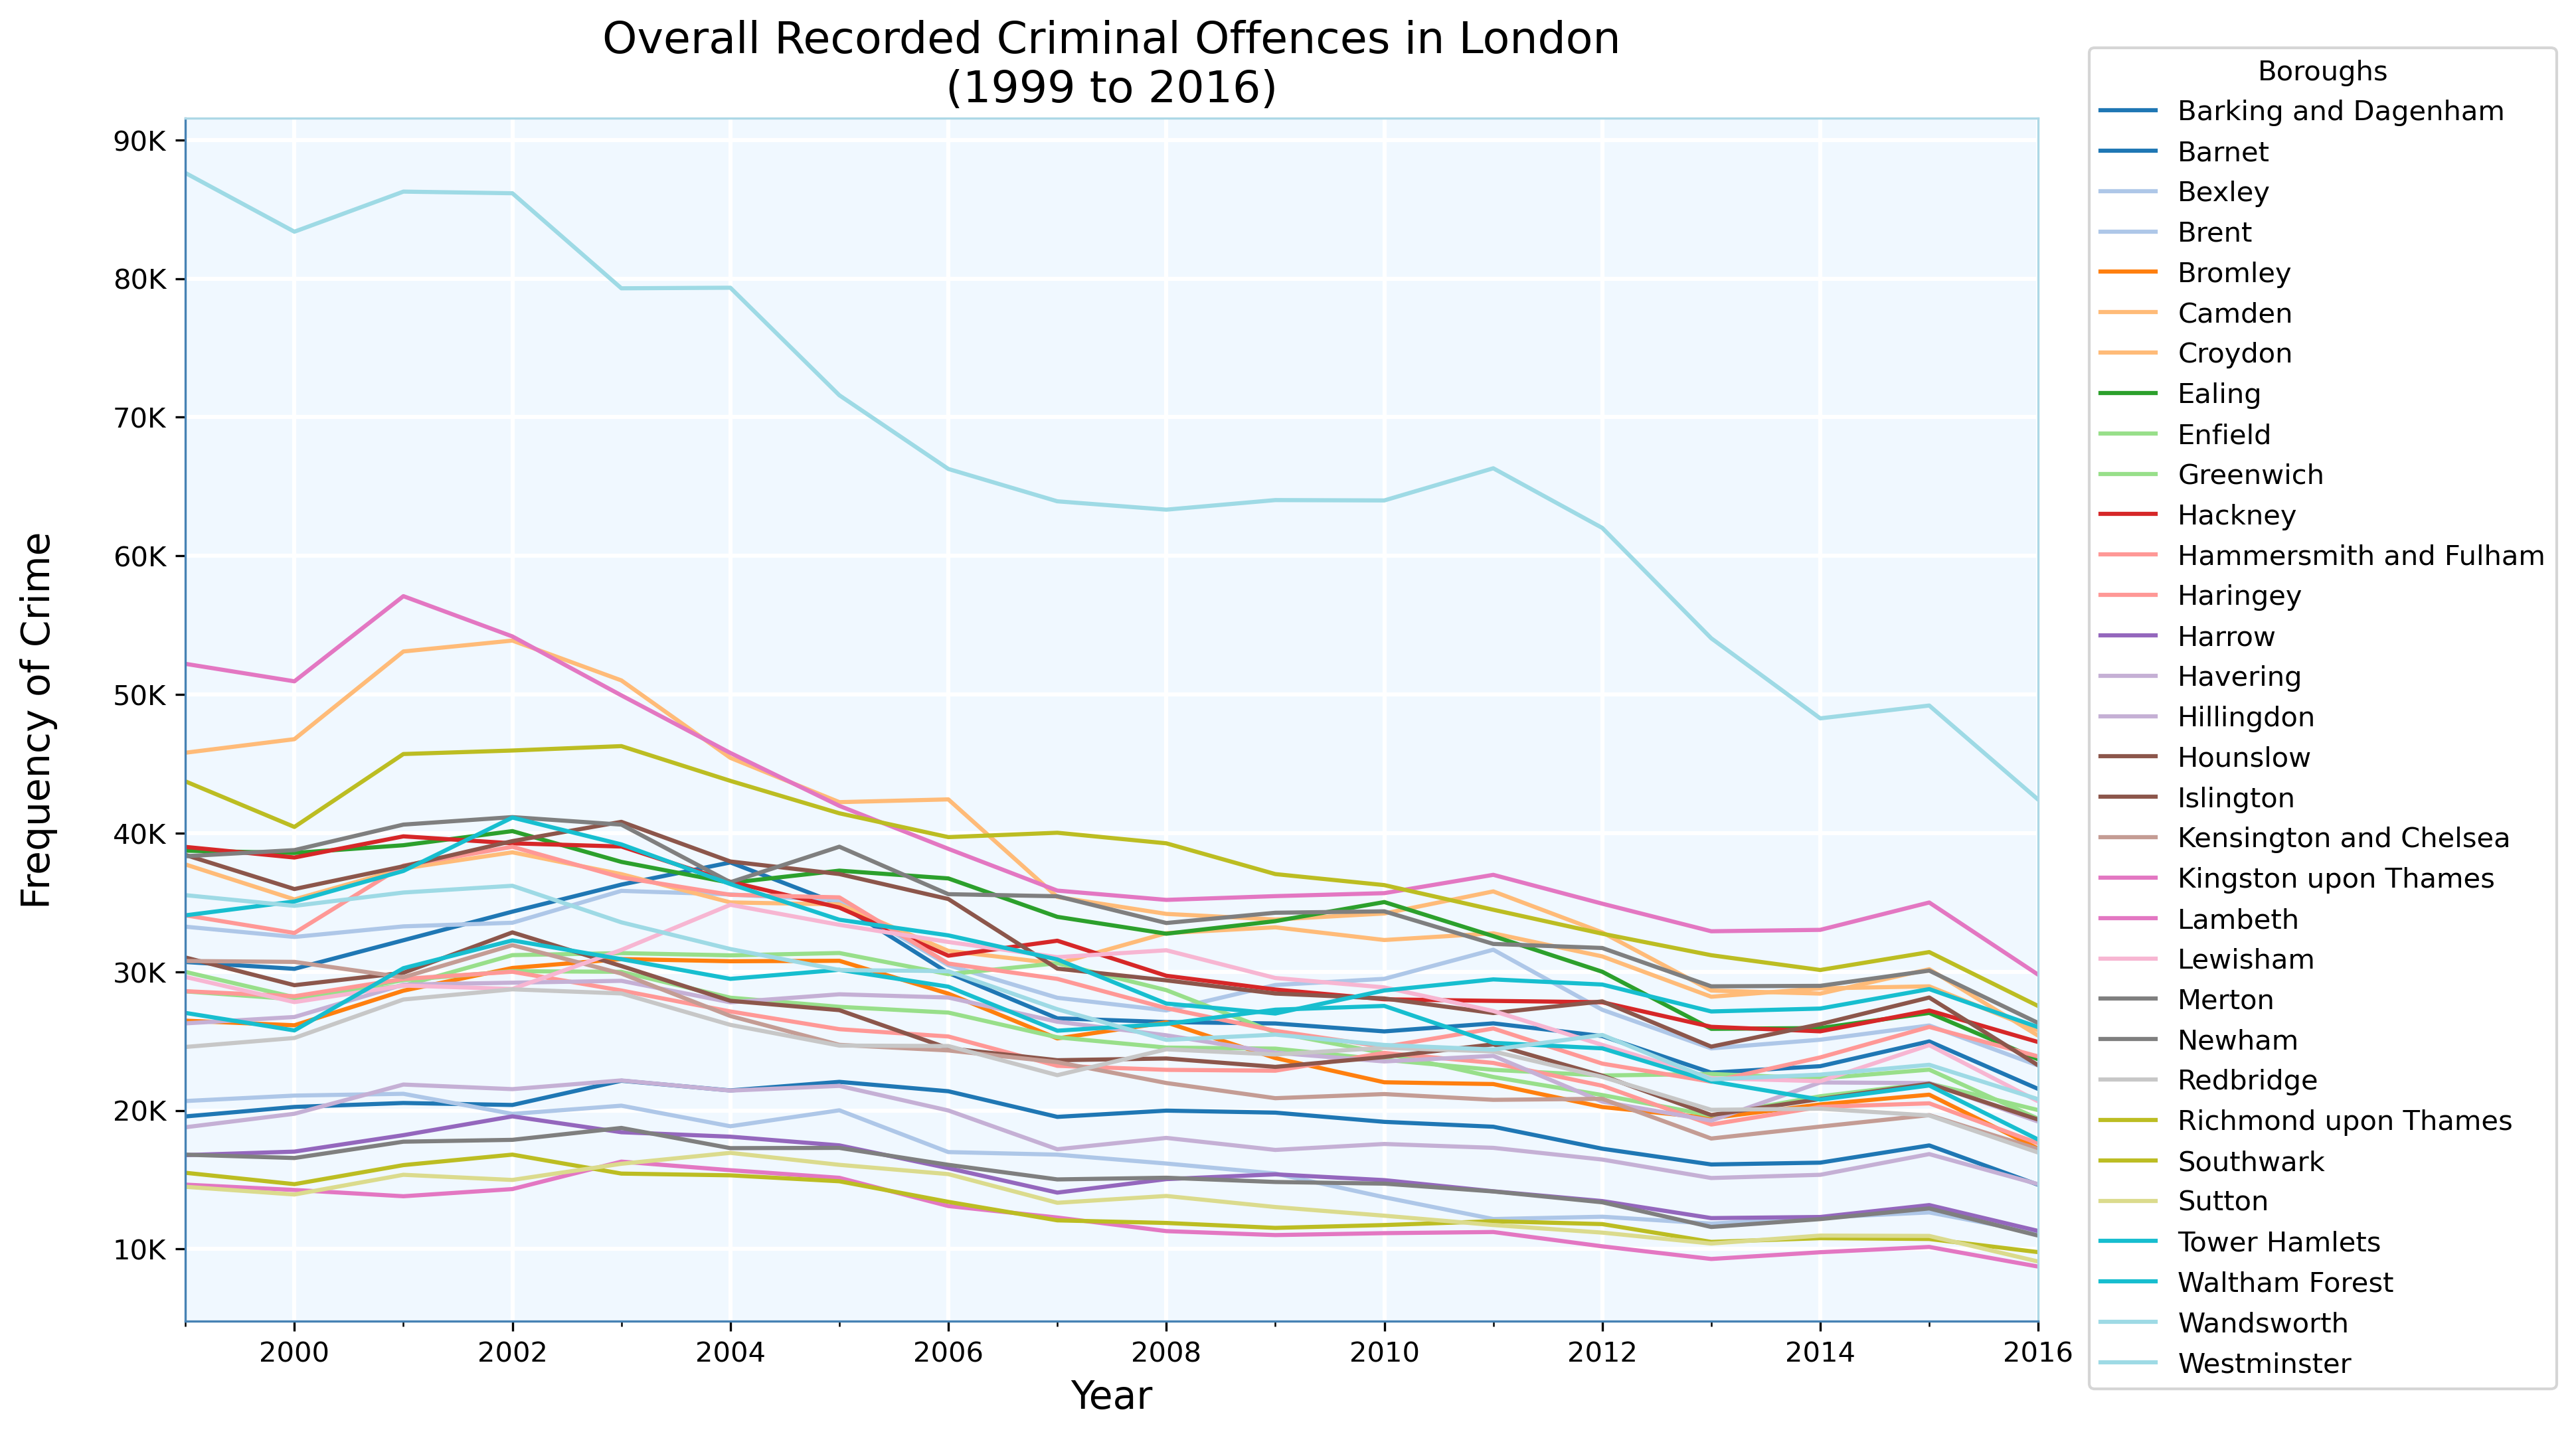

In [566]:
# calling the required rows and columns
# and setting boroughs as categorical
crime = pd.read_excel('crime_rates.xlsx', 
                      sheet_name = 'Recorded Offences',
                      skiprows = [0,2],
                      nrows=32,
                      usecols='B:T',
                      dtype = {
                          'Borough':'category'
                      }
                    )
# melting, change form to fit my needs later
crime_melt = crime.melt(id_vars=['Borough'], var_name='year', value_name='crime_freq')
crime_melt['year'] = pd.to_datetime(crime_melt['year'], format='%Y')
crime_melt.set_index('year', inplace=True)
crime_melt = crime_melt.to_period('Y')
crime_melt.set_index(['Borough'], inplace=True, append=True)

compA = crime_melt.loc[(slice(None), # years
                        slice(None), # Borough
                        ), 
                        :# column indexer
                      ]

ax = compA.unstack().plot(grid=True, colormap='tab20', figsize=(12,8))
index = compA.index.get_level_values('Borough').tolist()
ax.legend(index, title='Boroughs', bbox_to_anchor = (1.02, 1.07))
ax_title_xy(ax, 'Overall Recorded Criminal Offences in London\n(1999 to 2016)', 'Year', 'Frequency of Crime\n')
ytick_k(ax,0)
colours(1)
ax.grid(color='white', linewidth=1.5)
# Saving the graph into folder export
#plt.savefig('export/overall_1.png', bbox_inches='tight',facecolor='aliceblue', dpi = 350)
plt.show()

compA = crime_melt.loc[(['2010','2011', '2012','2013','2014','2015','2016'], # all years
                        slice(None), # Borough
                        ), 
                        :# column indexer
                      ]
index = compA.index.get_level_values('Borough').tolist()
ax = compA.unstack().plot(grid=True, colormap='tab20', figsize=(12,8))
ax.legend(index, title='Boroughs', bbox_to_anchor = (1.02, 1.07))


ax.set_title('Overall Recorded Crime Numbers\n(2010 to 2016)', fontsize = 14)
ytick_k(ax)
ax.set_ylabel('Frequency of crime\n', fontsize = '12')
ax.set_xlabel('Year', fontsize = '12')

colours(1)

ax.grid(color='white', linewidth=1.5)
plt.show()

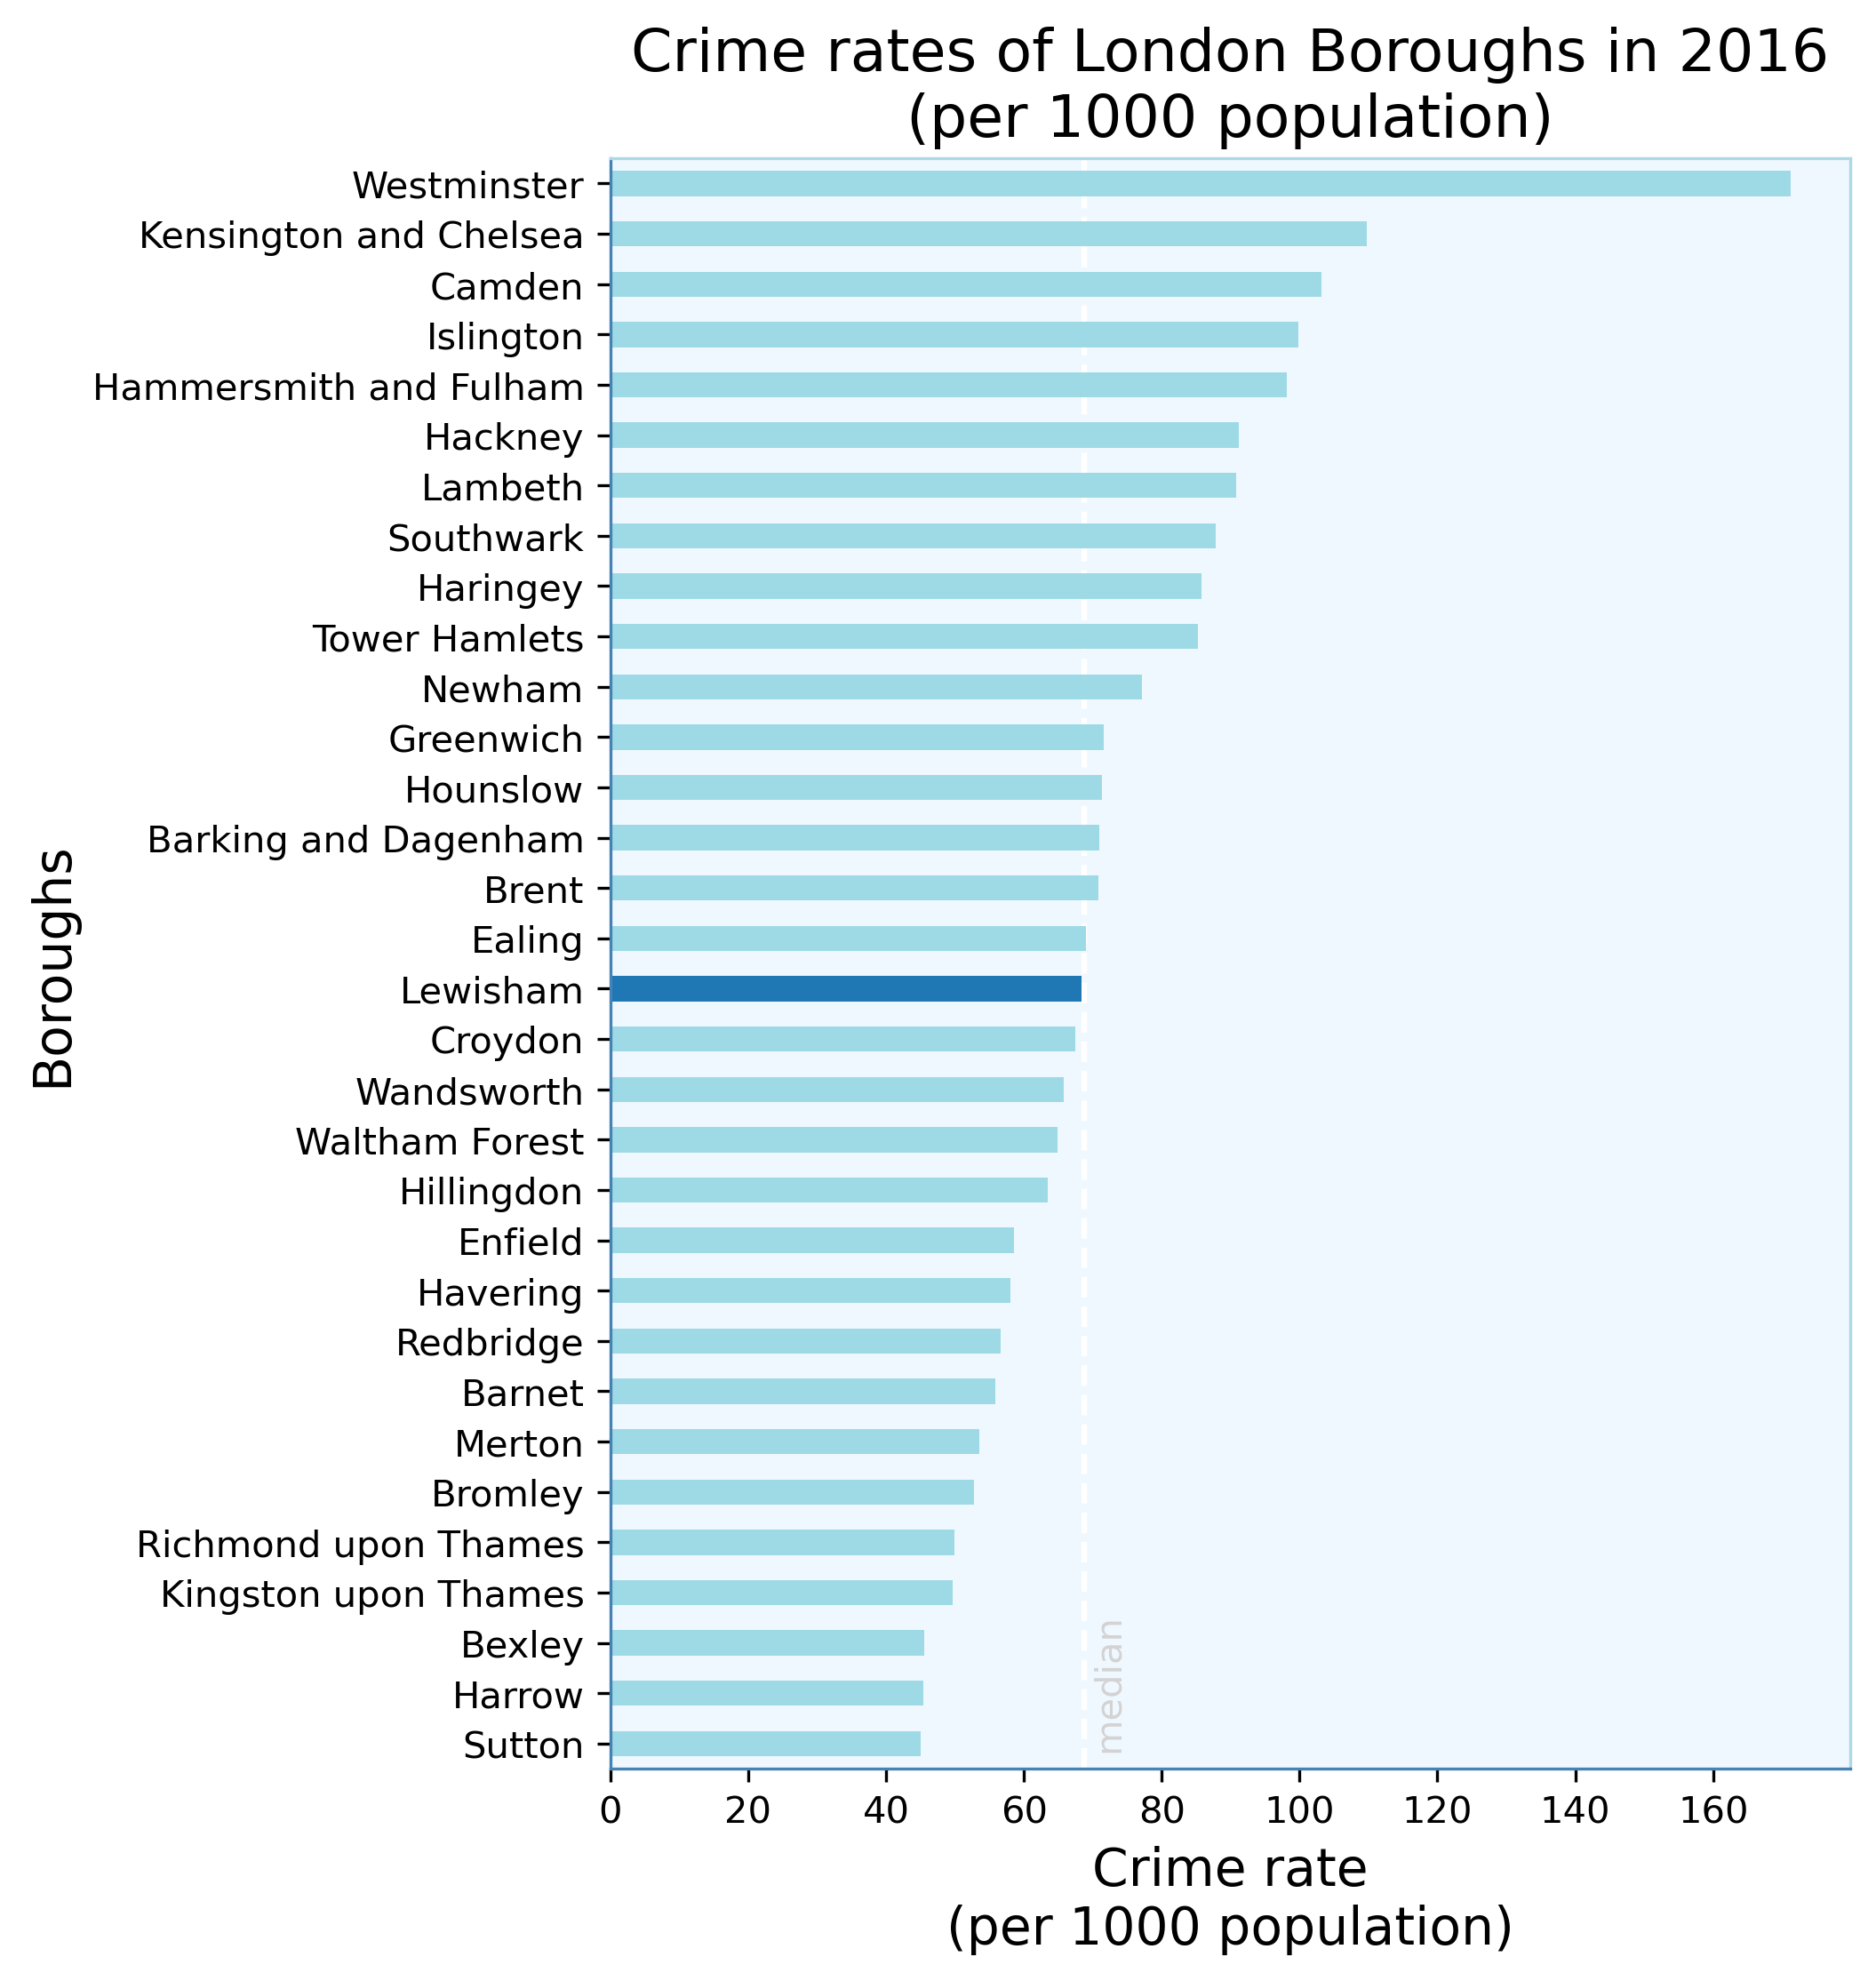

In [570]:
crime_r = pd.read_excel('crime_rates.xlsx', 
                         sheet_name = 'Crime Rates',
                         skiprows = [0,2],
                         nrows=32,
                         usecols='B:T',
                         dtype = {'Borough':'category'}
                        )
crime_r_melt = crime_r.melt(id_vars=['Borough'], var_name='year', value_name='crime_rate')

crime_r_melt['year'] = pd.to_datetime(crime_r_melt['year'], format='%Y')
crime_r_melt.set_index('year', inplace=True)
crime_r_melt = crime_r_melt.to_period('Y')
crime_r_melt.set_index(['Borough'], inplace=True, append=True)

compB = crime_r_melt.loc[('2016', # all years
                        slice(None), # boroughs ['Barnet']
                        ), 
                        :# column indexer
                    ]
#sorting bar chart by higher crime rate
ax = compB.groupby('Borough').sum().sort_values(by='crime_rate').plot.barh(
                                                                legend=False,
                                                                figsize=(6,8),
                                                                colormap='tab20_r')
ax_title_xy(ax, 'Crime rates of London Boroughs in 2016\n(per 1000 population)', 
            'Crime rate\n(per 1000 population)', 'Boroughs')

ax.axvline(compB.median()[0], linestyle='--', color='white', zorder=-1)
plt.text(compB.median()[0]+1,0,'median', rotation=90,color='lightgray')
colours(1)
ax.patches[15].set_facecolor('tab:blue')

#plt.savefig('export/overall_2.png', bbox_inches='tight',facecolor='aliceblue', dpi = 300)
plt.show()

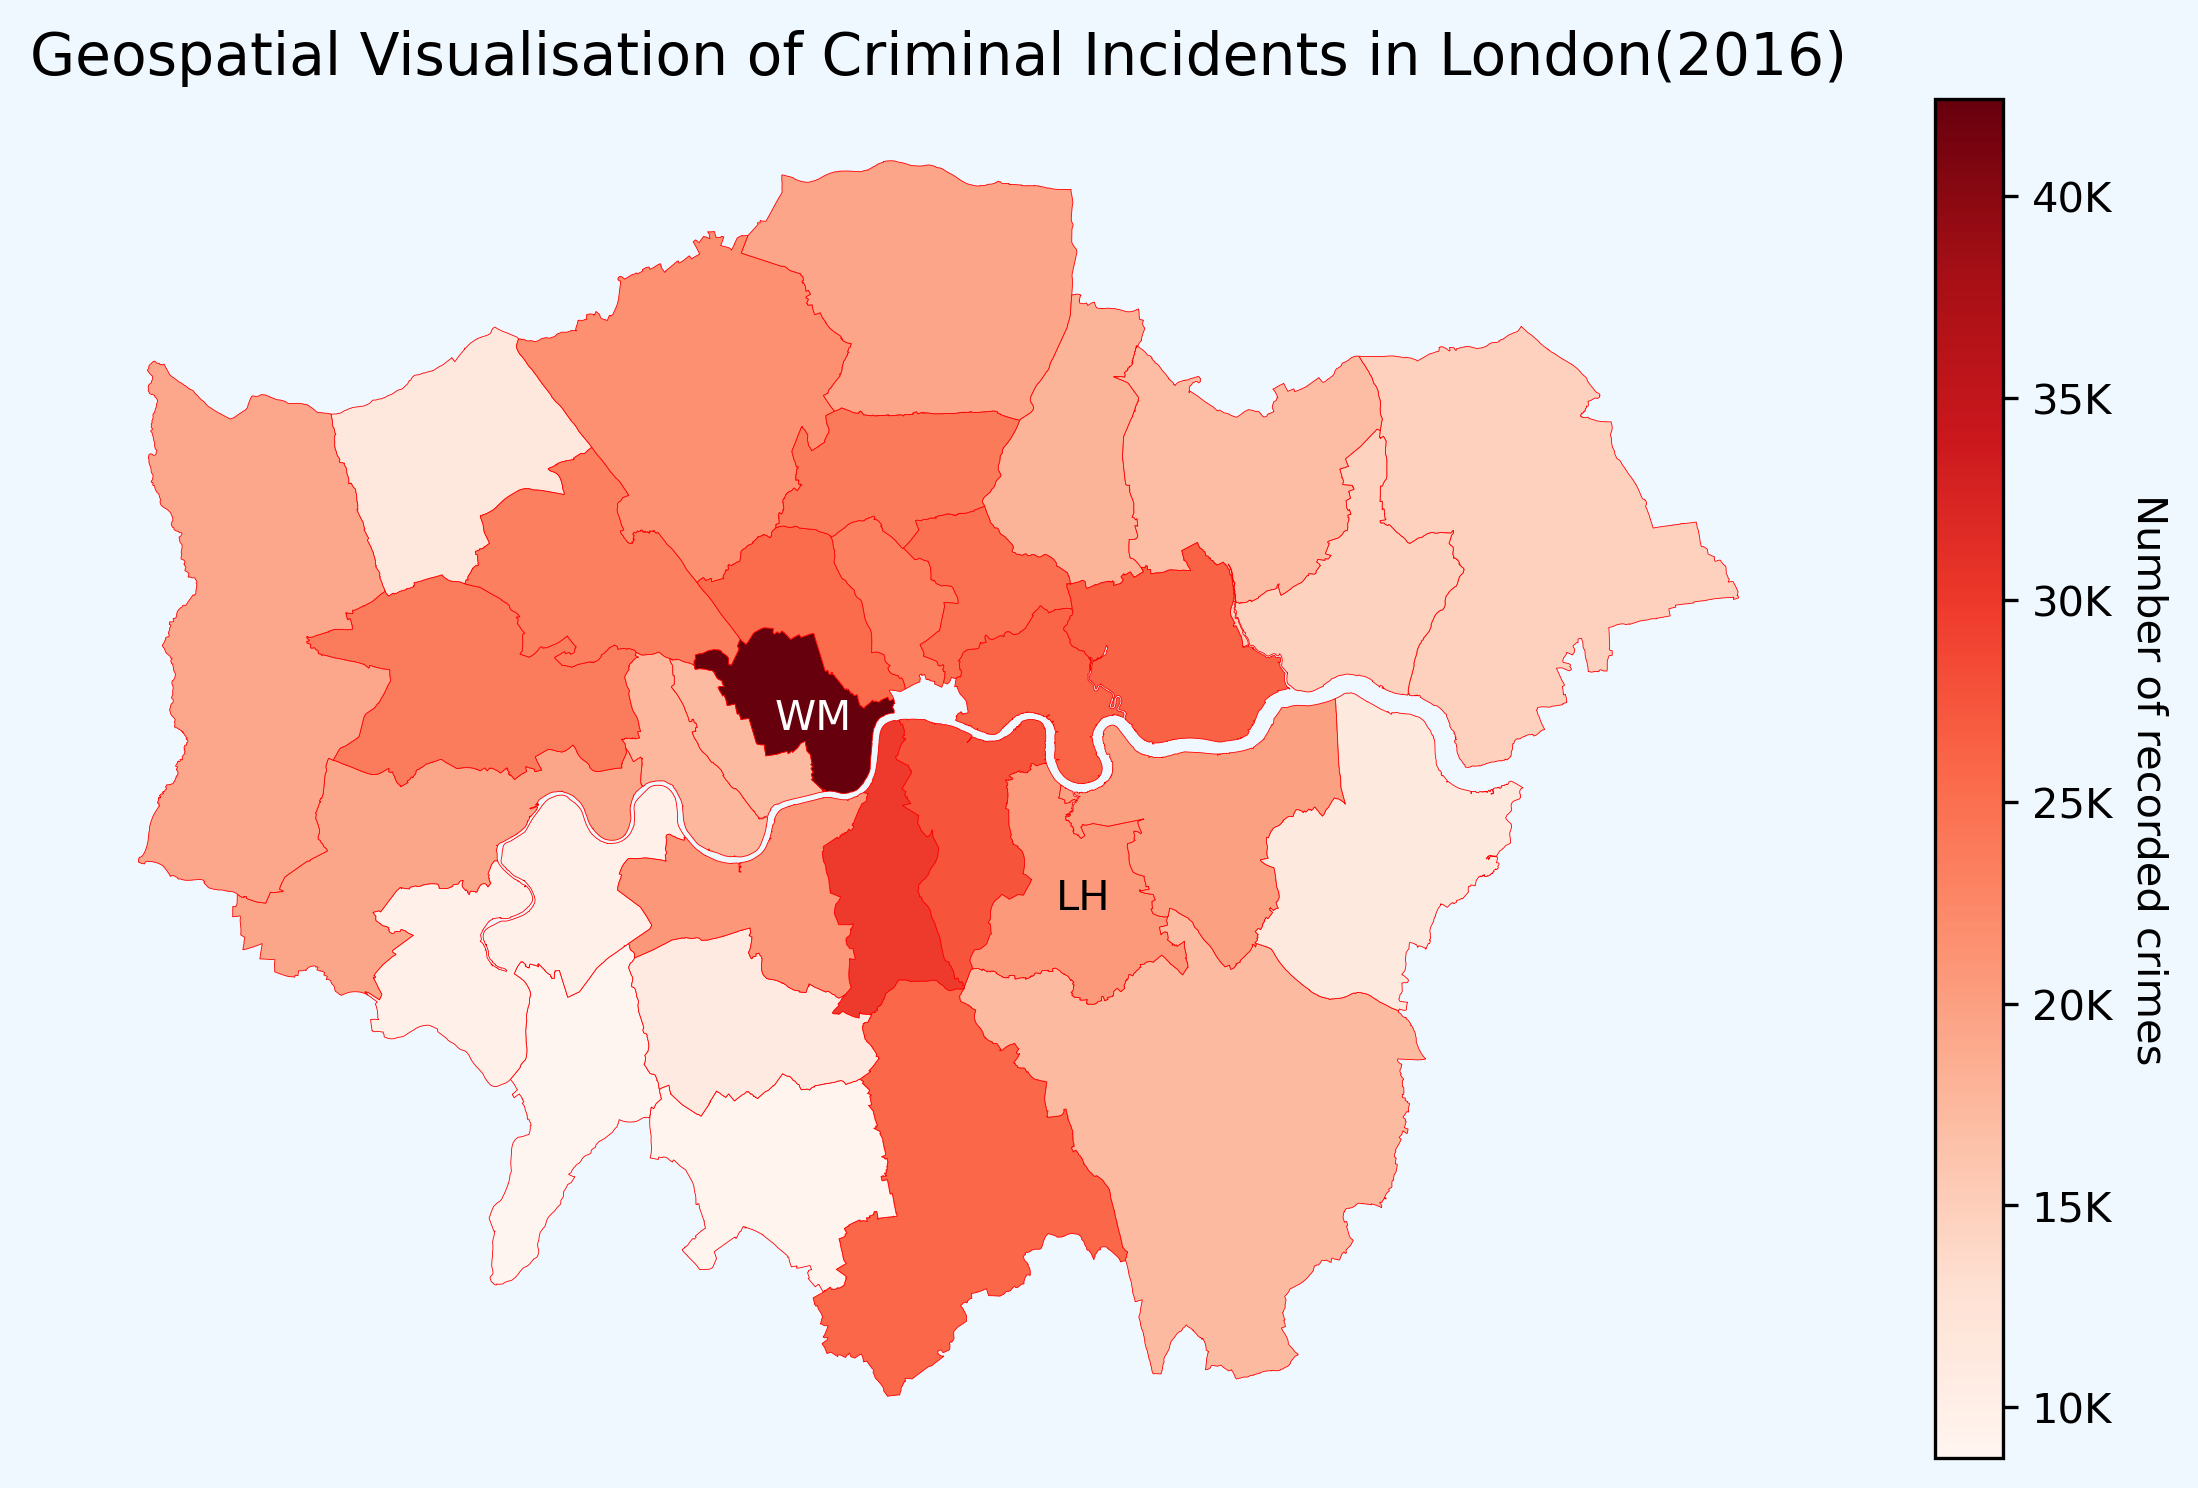

In [394]:
# map sourced from LONDON DATASTORE
fp = 'boundaries-london/ESRI/London_Borough_Excluding_MHW.shp'
# store the map in a dataframe
map_df = gpd.read_file(fp)
# the data to plot
comp2016 = crime_melt.loc[(['2016'], # years
                        slice(None) # Borough
                        ), 
                        :# column indexer
                      ]
comp2016 = comp2016.reset_index(level='Borough')
# merge the 2 df by borough names
merged = map_df.set_index('NAME').join(comp2016.set_index('Borough'))
fig, ax = plt.subplots(1, figsize=(10, 6))# subplot
# plotting with crime freq as data
merged.plot(column='crime_freq', cmap='Reds', linewidth=0.2, ax=ax, edgecolor='red')
ax.set_title('Geospatial Visualisation of Criminal Incidents in London(2016)', fontsize=14)
ax.axis('off')
fig.set_facecolor('aliceblue')
# storing the min and max
vmin = merged['crime_freq'].min()
vmax = merged['crime_freq'].max()
# colour map as key
sm = plt.cm.ScalarMappable(cmap = 'Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
bar = fig.colorbar(sm)
bar.set_ticks(bar.get_ticks())
bar.set_ticklabels(['10K', '15K', '20K', '25K', '30K', '35K', '40K'])
bar.set_label('Number of recorded crimes', rotation=-90, va='bottom')
# labelling the map itself
fig.text(0.5, # x position
        0.43, # y position
        'LH', # string
        horizontalalignment='center') # alignment
fig.text(0.41, # x position
        0.53, # y position
        'WM', # string
        horizontalalignment='center',color='white') # alignment

#plt.savefig('export/overall_3_geomap.png', bbox_inches='tight', dpi = 350)

plt.show()

In [452]:
# changes the colum name(this is specific to only few graphs)
def colNameYear(df,nameIdx):
    columnA = np.arange(1998,2017,1,object)
    columnA[0] = nameIdx
    df.columns = columnA
    # call like - colName(df, 'borough')
    
#returns a melted df with a df inputed
def allOffences_melt(df, _val):
    df = df.melt(id_vars=['Borough'], var_name='year', value_name=_val)
    df['year'] = pd.to_datetime(df['year'], format='%Y')
    df.set_index('year', inplace=True)
    df = df.to_period('Y')
    return df
# function for returning a df with parameters specified
def allOffences(sheet,_rowRange, cols, offence):
    if sheet == 0:
        sheet_n = 'Crime Rates'
    elif sheet ==1:
        sheet_n = 'Recorded Offences'
    rows = np.delete(_rowRange,1)
    df = pd.read_excel('crime_rates.xlsx', 
                      sheet_name = sheet_n,
                      skiprows = rows,
                      nrows= 1,
                      usecols=cols,
                      dtype = {
                          'Borough':'category'
                      },
                    )
    colNameYear(df, 'Borough')
    df = allOffences_melt(df, offence)
    return df


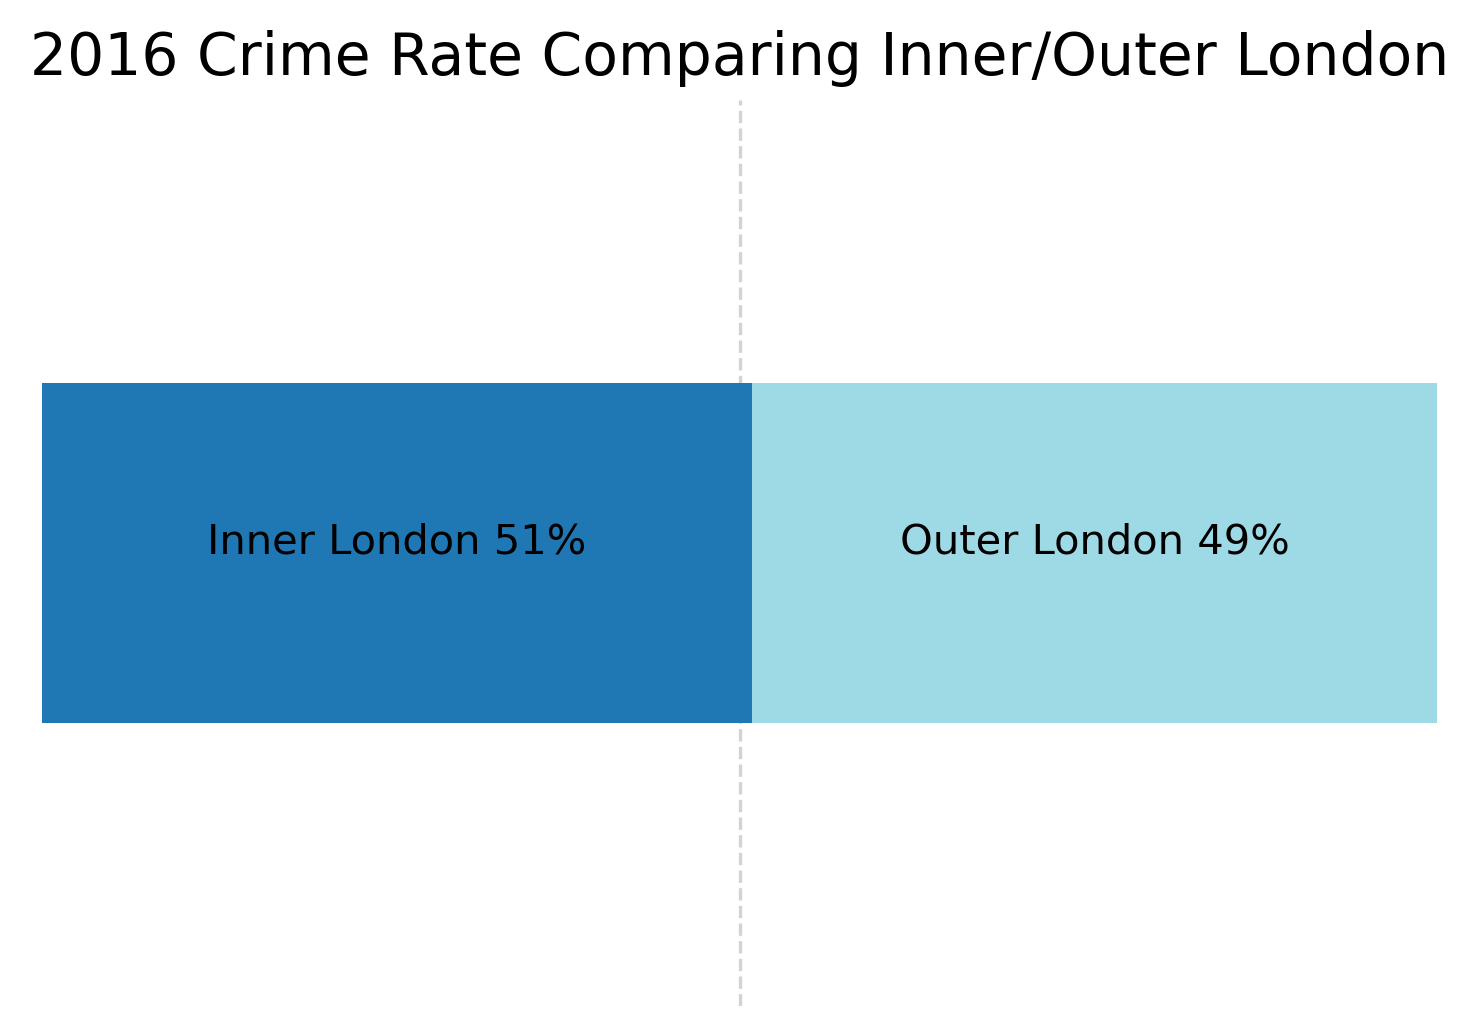

In [369]:
#univariate plot of inner and outer london crime rate
s_row = np.delete(np.arange(0,36,1),1)
in_out = pd.read_excel('crime_rates.xlsx', 
                         sheet_name = 'Recorded Offences',
                         skiprows = s_row,
                         nrows=2,
                         usecols='B:T',
                         dtype = {'Borough':'category'},
                       index_col='Borough'
                        )



def perc(year):
    return in_out[year]/in_out[year].sum() * 100

pc = perc(2016)
ax = pc.to_frame().T.plot.barh(cmap='tab20',stacked=True, legend=False,width=0.3)
ax.axvline(50, linewidth=0.8,linestyle='--', color='lightgrey', zorder=-1 )
ax.axis('off')
def format_label(category):
    return '{} {:.0f}%'.format(category.title(), pc[category])
# placing labels on top of bars
ax.text(pc['Inner London'] / 2, # x position
        0, # y position
        format_label('Inner London'), # string
        horizontalalignment='center') # alignment
        # Add salted percent label.
ax.text(pc['Inner London'] + pc['Outer London'] / 2, # x position
        0, # y position
        format_label('Outer London'), # string
        horizontalalignment='center') # alignment
ax.set_title('2016 Crime Rate Comparing Inner/Outer London',fontsize=14)
ax.set_xlim(0,100)

ax.patch.set_facecolor('aliceblue')
#plt.savefig('export/innerOuter.png', bbox_inches='tight',facecolor='aliceblue', dpi = 350)

plt.show()



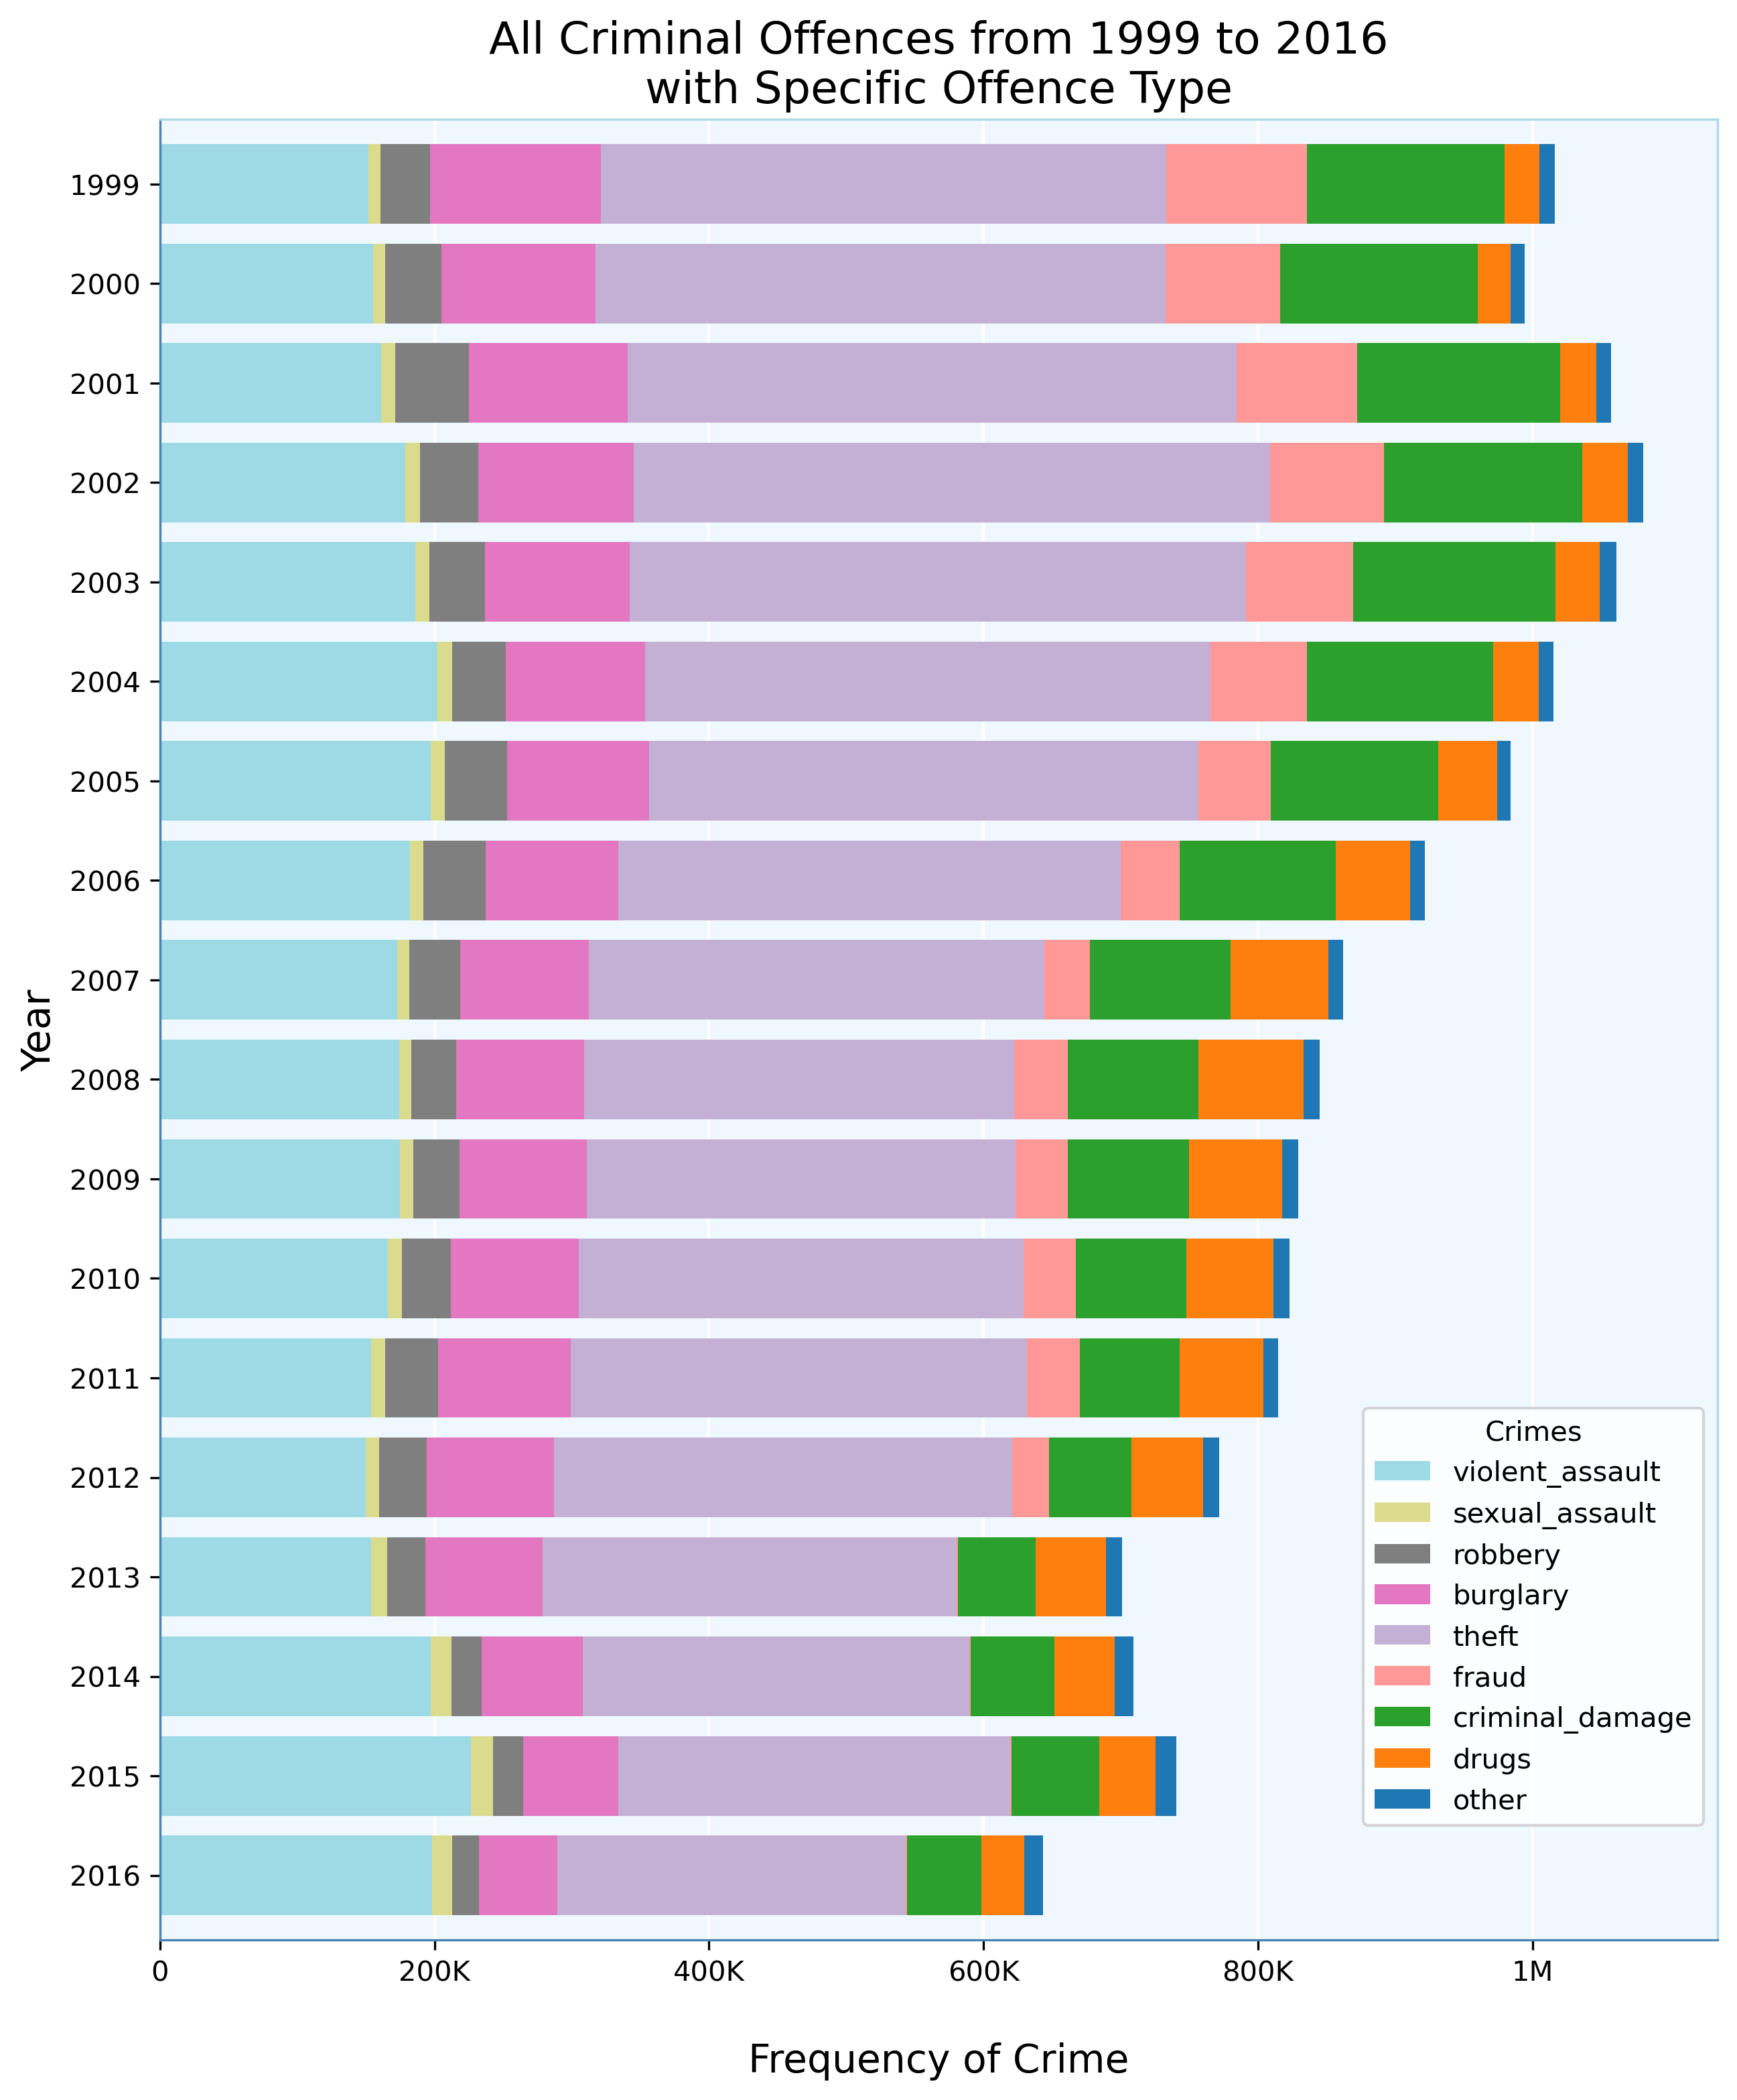

In [634]:
# full frequency
rowRange = np.arange(0,39,1)
# calling function that returns a dataframe
v_offence = allOffences(1,rowRange, 'B,U:Al','violent_assault')
s_offence = allOffences(1,rowRange, 'B,AM:BD','sexual_assault')
robbery = allOffences(1, rowRange, 'B,BE:BV','robbery')
burglary = allOffences(1, rowRange, 'B,BW:CN','burglary')
theft = allOffences(1, rowRange, 'B,CO:DF','theft')
fraud = allOffences(1,rowRange, 'B,DG:DX','fraud')
crim_damage = allOffences(1,rowRange, 'B,DY:EP','criminal_damage')
drugs = allOffences(1,rowRange, 'B,EQ:FH','drugs')
other = allOffences(1,rowRange, 'B,FI:FZ','other')
# joining together all the dfs
offences = pd.concat([ v_offence['violent_assault'], s_offence['sexual_assault'], 
                        robbery['robbery'], burglary['burglary'],
                        theft['theft'], fraud['fraud'],
                        crim_damage['criminal_damage'], drugs['drugs'],
                        other['other']
                     ],
                     axis=1)
# plotting
ax = offences.plot.barh(stacked=True,colormap='tab20_r', figsize=(10,12), width=0.8, zorder=2.5)
colours(1)
ax.legend( title='Crimes', bbox_to_anchor = (1.0, 0.3))

xtick = ax.get_xticks()
ax.xaxis.set_major_locator(mticker.FixedLocator(xtick))
new_tick = ['{:,.0f}'.format(x/1000 ) + 'K' if x< 1000000 else '1M' for x in xtick ]
new_tick[0] = '0'
ax.set_xticklabels(new_tick)
ax.xaxis.grid(zorder=0, color='white', linewidth=1)
ax_title_xy(ax, 'All Criminal Offences from 1999 to 2016\nwith Specific Offence Type',
           '\nFrequency of Crime', 'Year')
#invert y axis
plt.gca().invert_yaxis()
#plt.savefig('export/specific_crime_frequency.png', bbox_inches='tight',facecolor='aliceblue', dpi = 350)
plt.show()

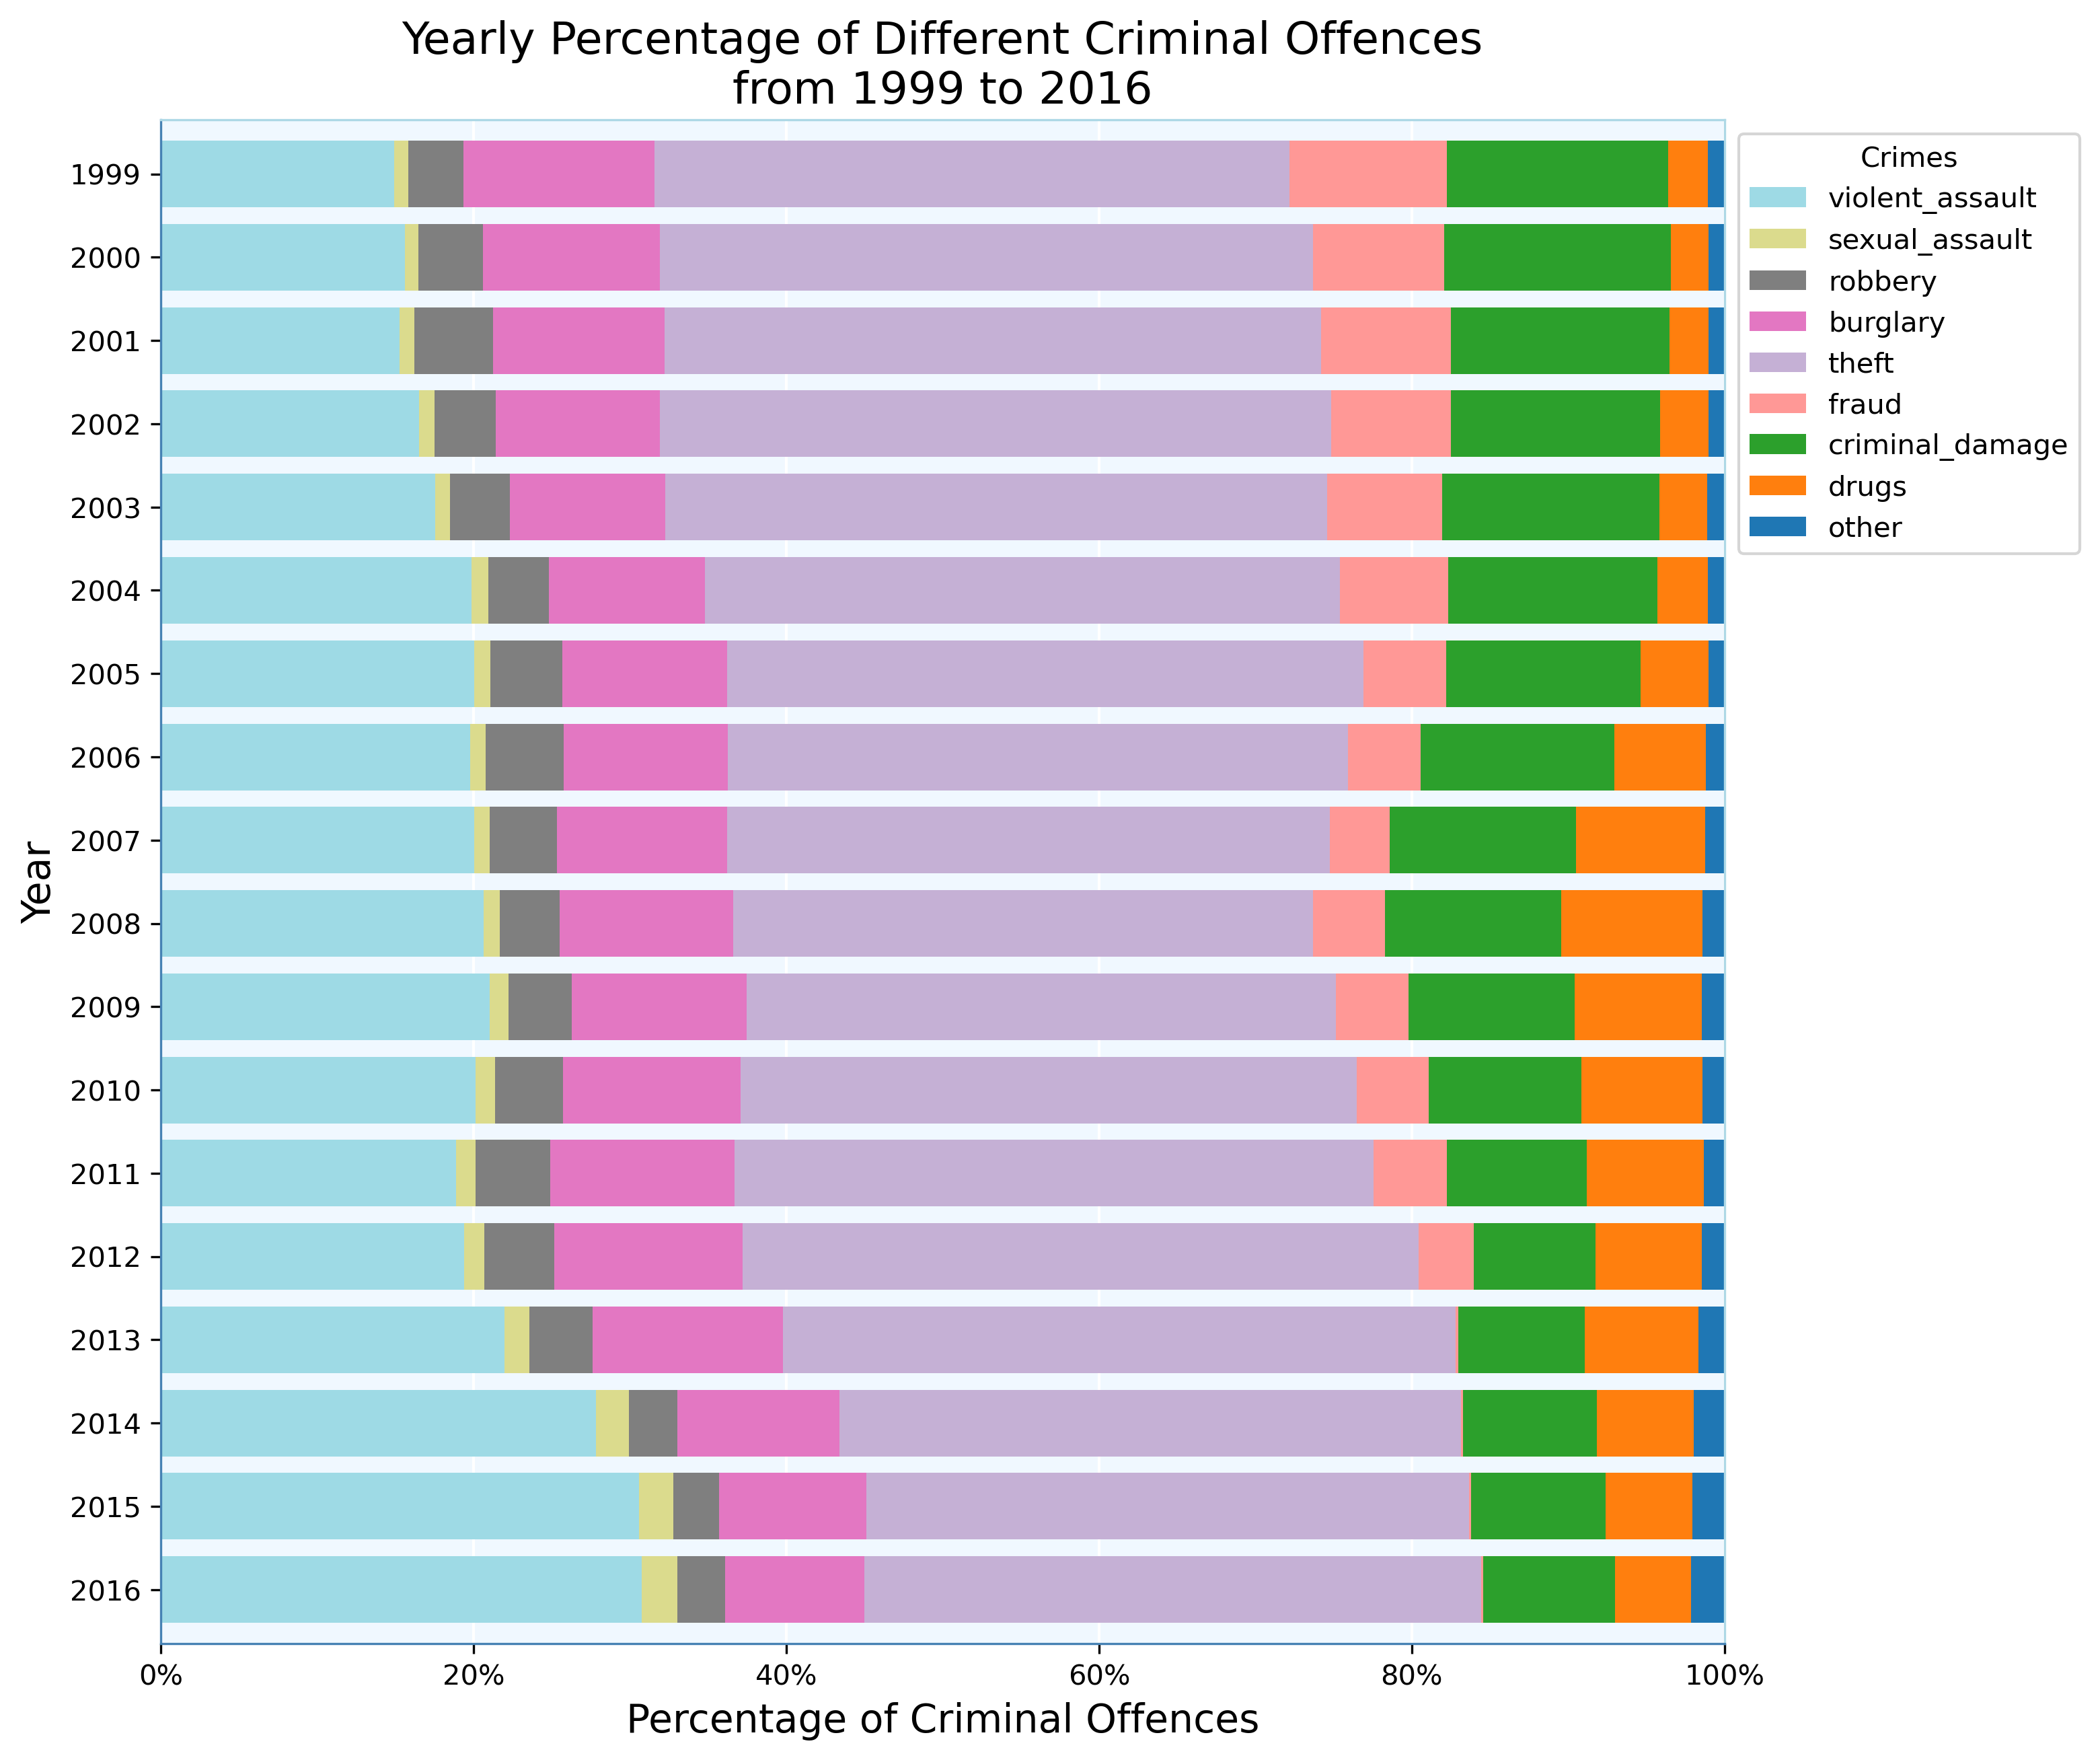

In [635]:
# normalised stacked chart, shows percentages
offences2 = offences.copy()
offences2.iloc[:,:] = Normalizer(norm='l1').fit_transform(offences2)*100
ax = offences2.plot.barh(stacked = True, colormap='tab20_r', 
                         figsize=(10,10),width=0.8, zorder=2.5)
ax.legend( title='Crimes', bbox_to_anchor = (1.0, 1.0))
ax.set_xlim(0,100)
colours(1)
xtick = ax.get_xticks()
ax.xaxis.set_major_locator(mticker.FixedLocator(xtick))
# changing the x ticks to something appropriate
ax.set_xticklabels([ '{:,.0f}'.format(x) + '%' for x in xtick ])
ax.xaxis.grid(zorder=0, color='white', linewidth=1)
ax_title_xy(ax,'Yearly Percentage of Different Criminal Offences\nfrom 1999 to 2016', 'Percentage of Criminal Offences', 'Year')
plt.gca().invert_yaxis()
plt.savefig('export/specific_crime_percent.png', bbox_inches='tight',facecolor='aliceblue', dpi = 350)
plt.show()

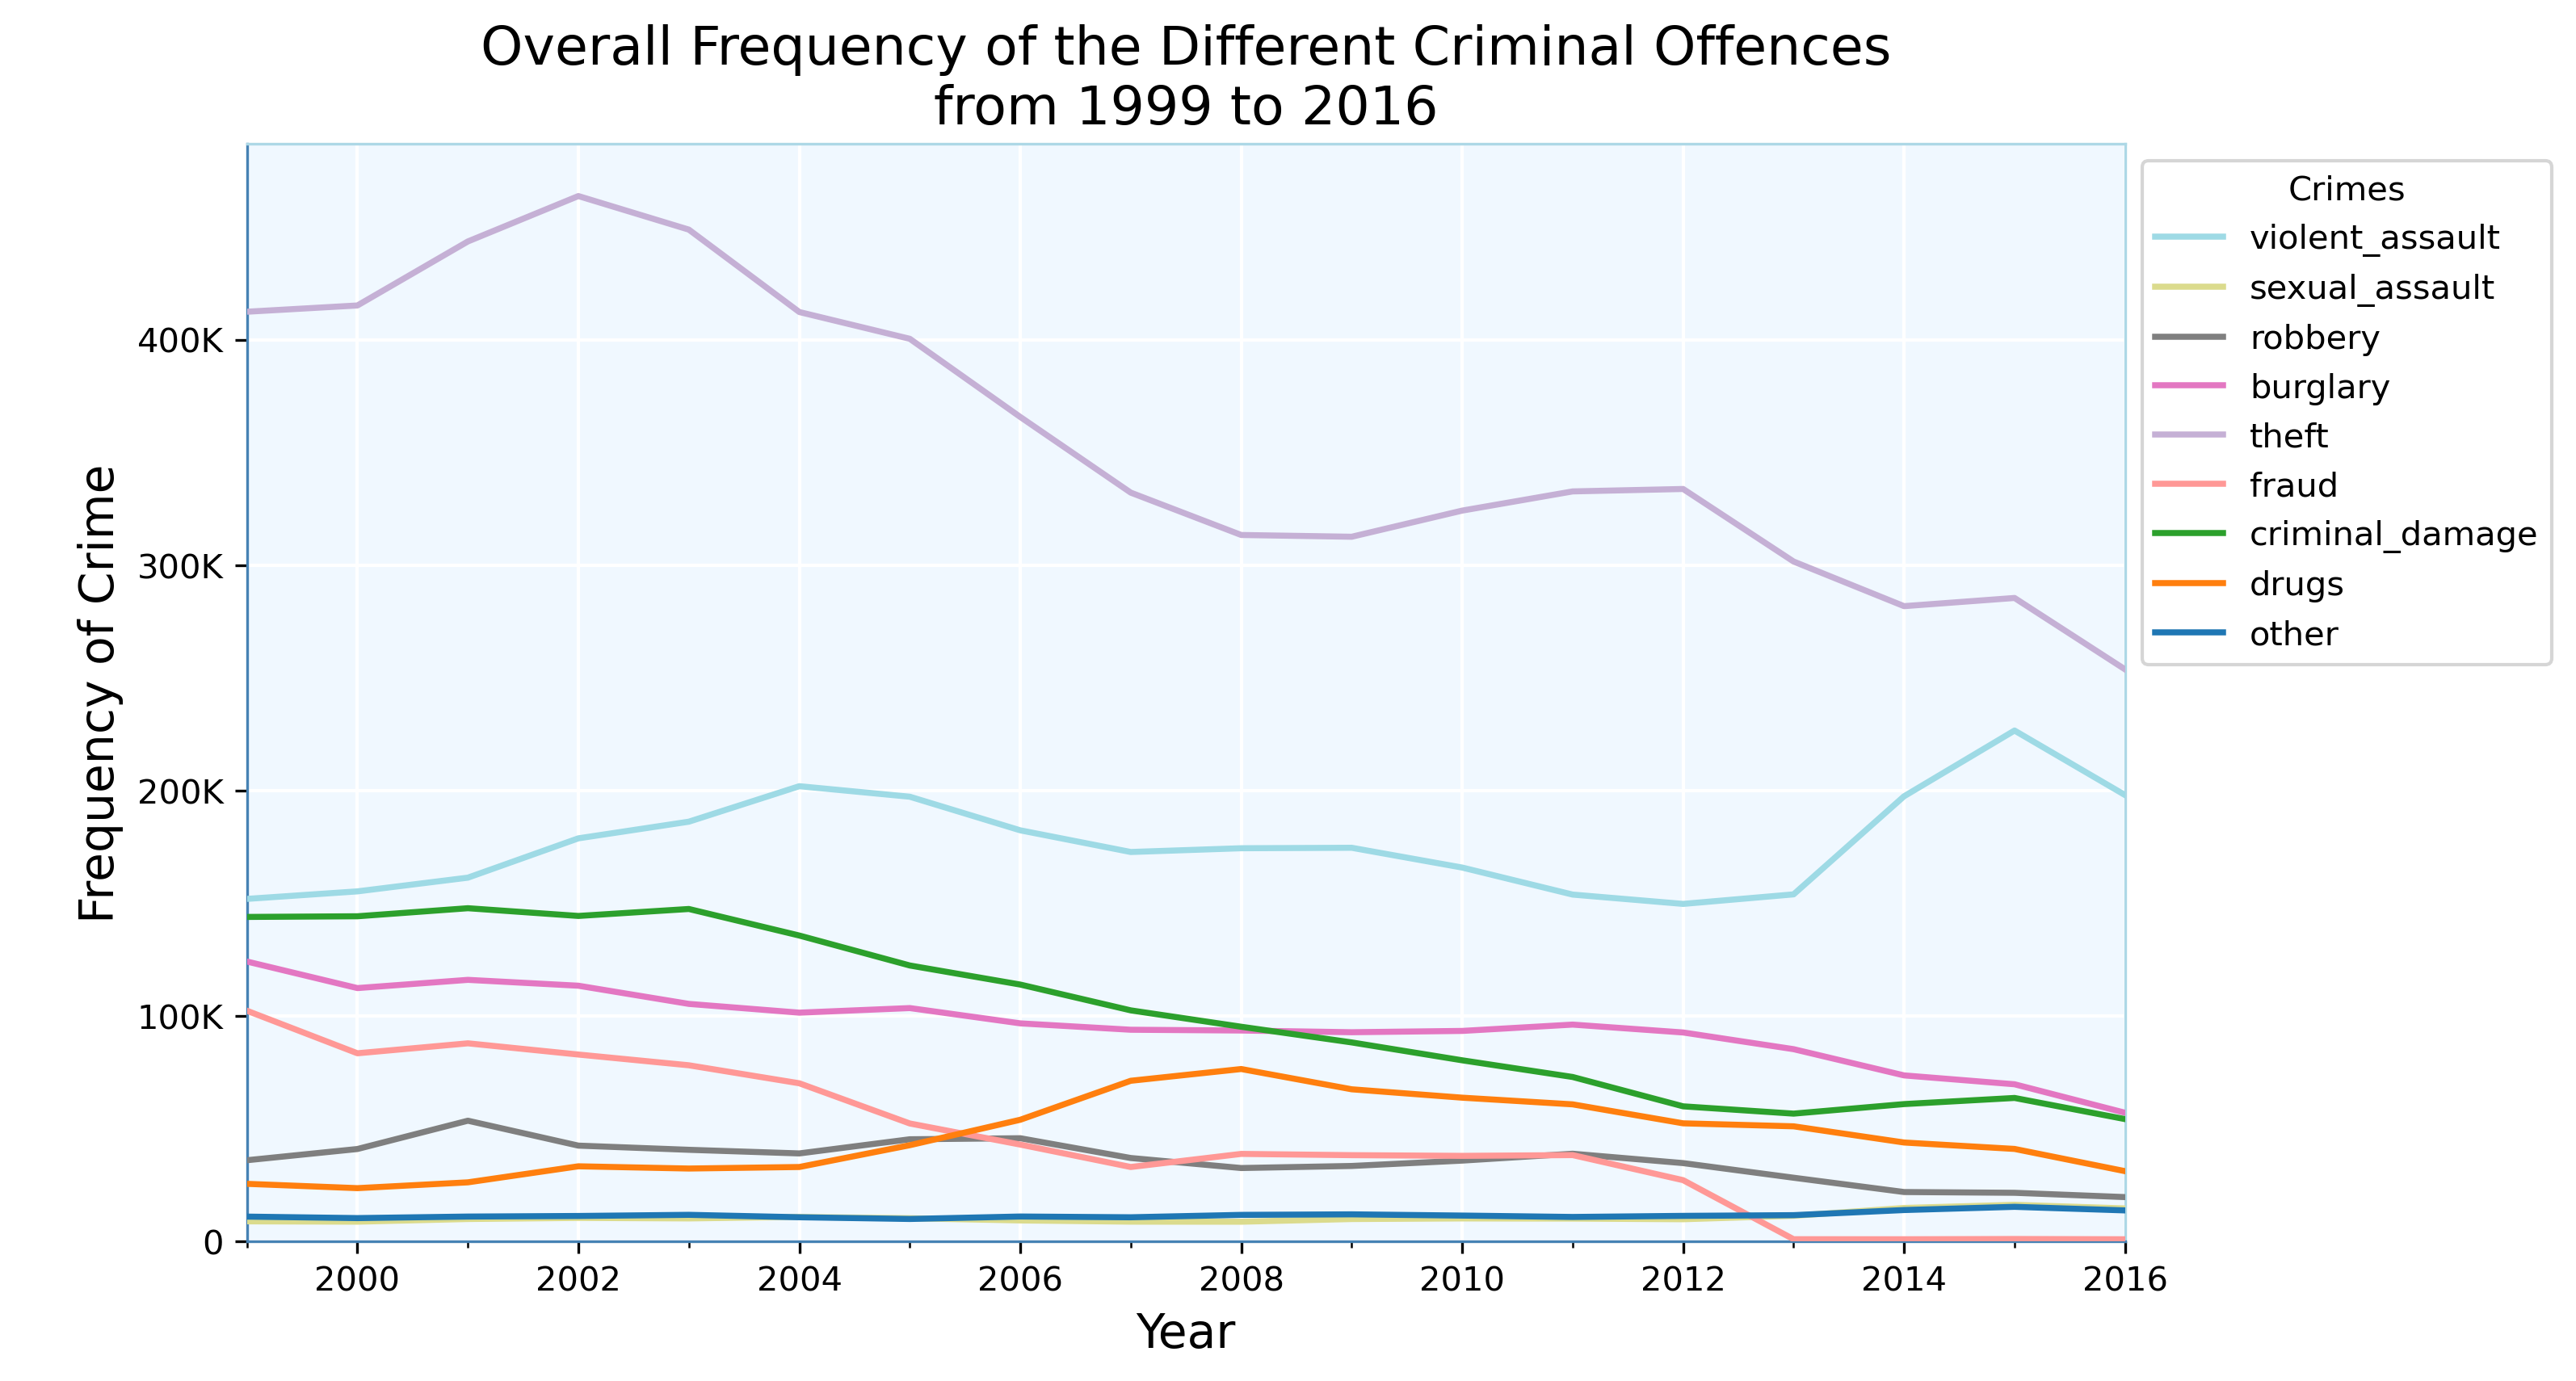

In [573]:
# time series
ax = offences.plot(grid=True, colormap='tab20_r', figsize = (10,6), linewidth = 1.8, zorder=2.6)
colours(1)
ax.grid(color='white', linewidth=1.0)
ax.legend( title='Crimes', bbox_to_anchor = (1.0, 1.0))
ax.set_ylim(0)# set y lim as it started from further up
ytick_k(ax,0)# change y tick, previously defined function
ax_title_xy(ax, 'Overall Frequency of the Different Criminal Offences\nfrom 1999 to 2016',
           'Year', '\nFrequency of Crime')

plt.savefig('export/specific_crime_time.png', bbox_inches='tight',facecolor='aliceblue', dpi = 350)
plt.show()

In [600]:
rowRange = np.arange(0,24,1)#specify range of rows
v_offence = allOffences(1, rowRange, 'B,U:Al','violent_assault')
s_offence = allOffences(1, rowRange, 'B,AM:BD','sexual_assault')
robbery = allOffences(1, rowRange, 'B,BE:BV','robbery')
burglary = allOffences(1, rowRange, 'B,BW:CN','burglary')
theft = allOffences(1, rowRange, 'B,CO:DF','theft')
fraud = allOffences(1, rowRange, 'B,DG:DX','fraud')
crim_damage = allOffences(1, rowRange, 'B,DY:EP','criminal_damage')
drugs = allOffences(1, rowRange, 'B,EQ:FH','drugs')
other = allOffences(1, rowRange, 'B,FI:FZ','other')
# joining
lewisham = pd.concat([ v_offence['violent_assault'], s_offence['sexual_assault'], 
                        robbery['robbery'], burglary['burglary'],
                        theft['theft'], fraud['fraud'],
                        crim_damage['criminal_damage'], drugs['drugs'],
                        other['other']
                     ],
                     axis=1)
# plot
ax = lewisham.plot.barh(stacked=True,colormap='tab20_r', figsize=(10,12), width=0.8, zorder=2.5)
colours(1)
ax.legend( title='Crimes', bbox_to_anchor = (1.0, 1.0))

xtick = ax.get_xticks()
ax.xaxis.set_major_locator(mticker.FixedLocator(xtick))
ax.set_xticklabels(['{:,.0f}'.format(x/1000 ) + 'K' if x> 0 else '0' for x in xtick ])
ax.xaxis.grid(zorder=0, color='white', linewidth=1)
# set title
ax_title_xy(ax, 'Different Criminal Offences in Lewisham\nfrom 1999 to 2016',
              'Frequency of Crime','Year')
# invert axis
plt.gca().invert_yaxis()
plt.savefig('export/lewisham_all_crime.png', bbox_inches='tight',facecolor='aliceblue', dpi = 350)
plt.show()

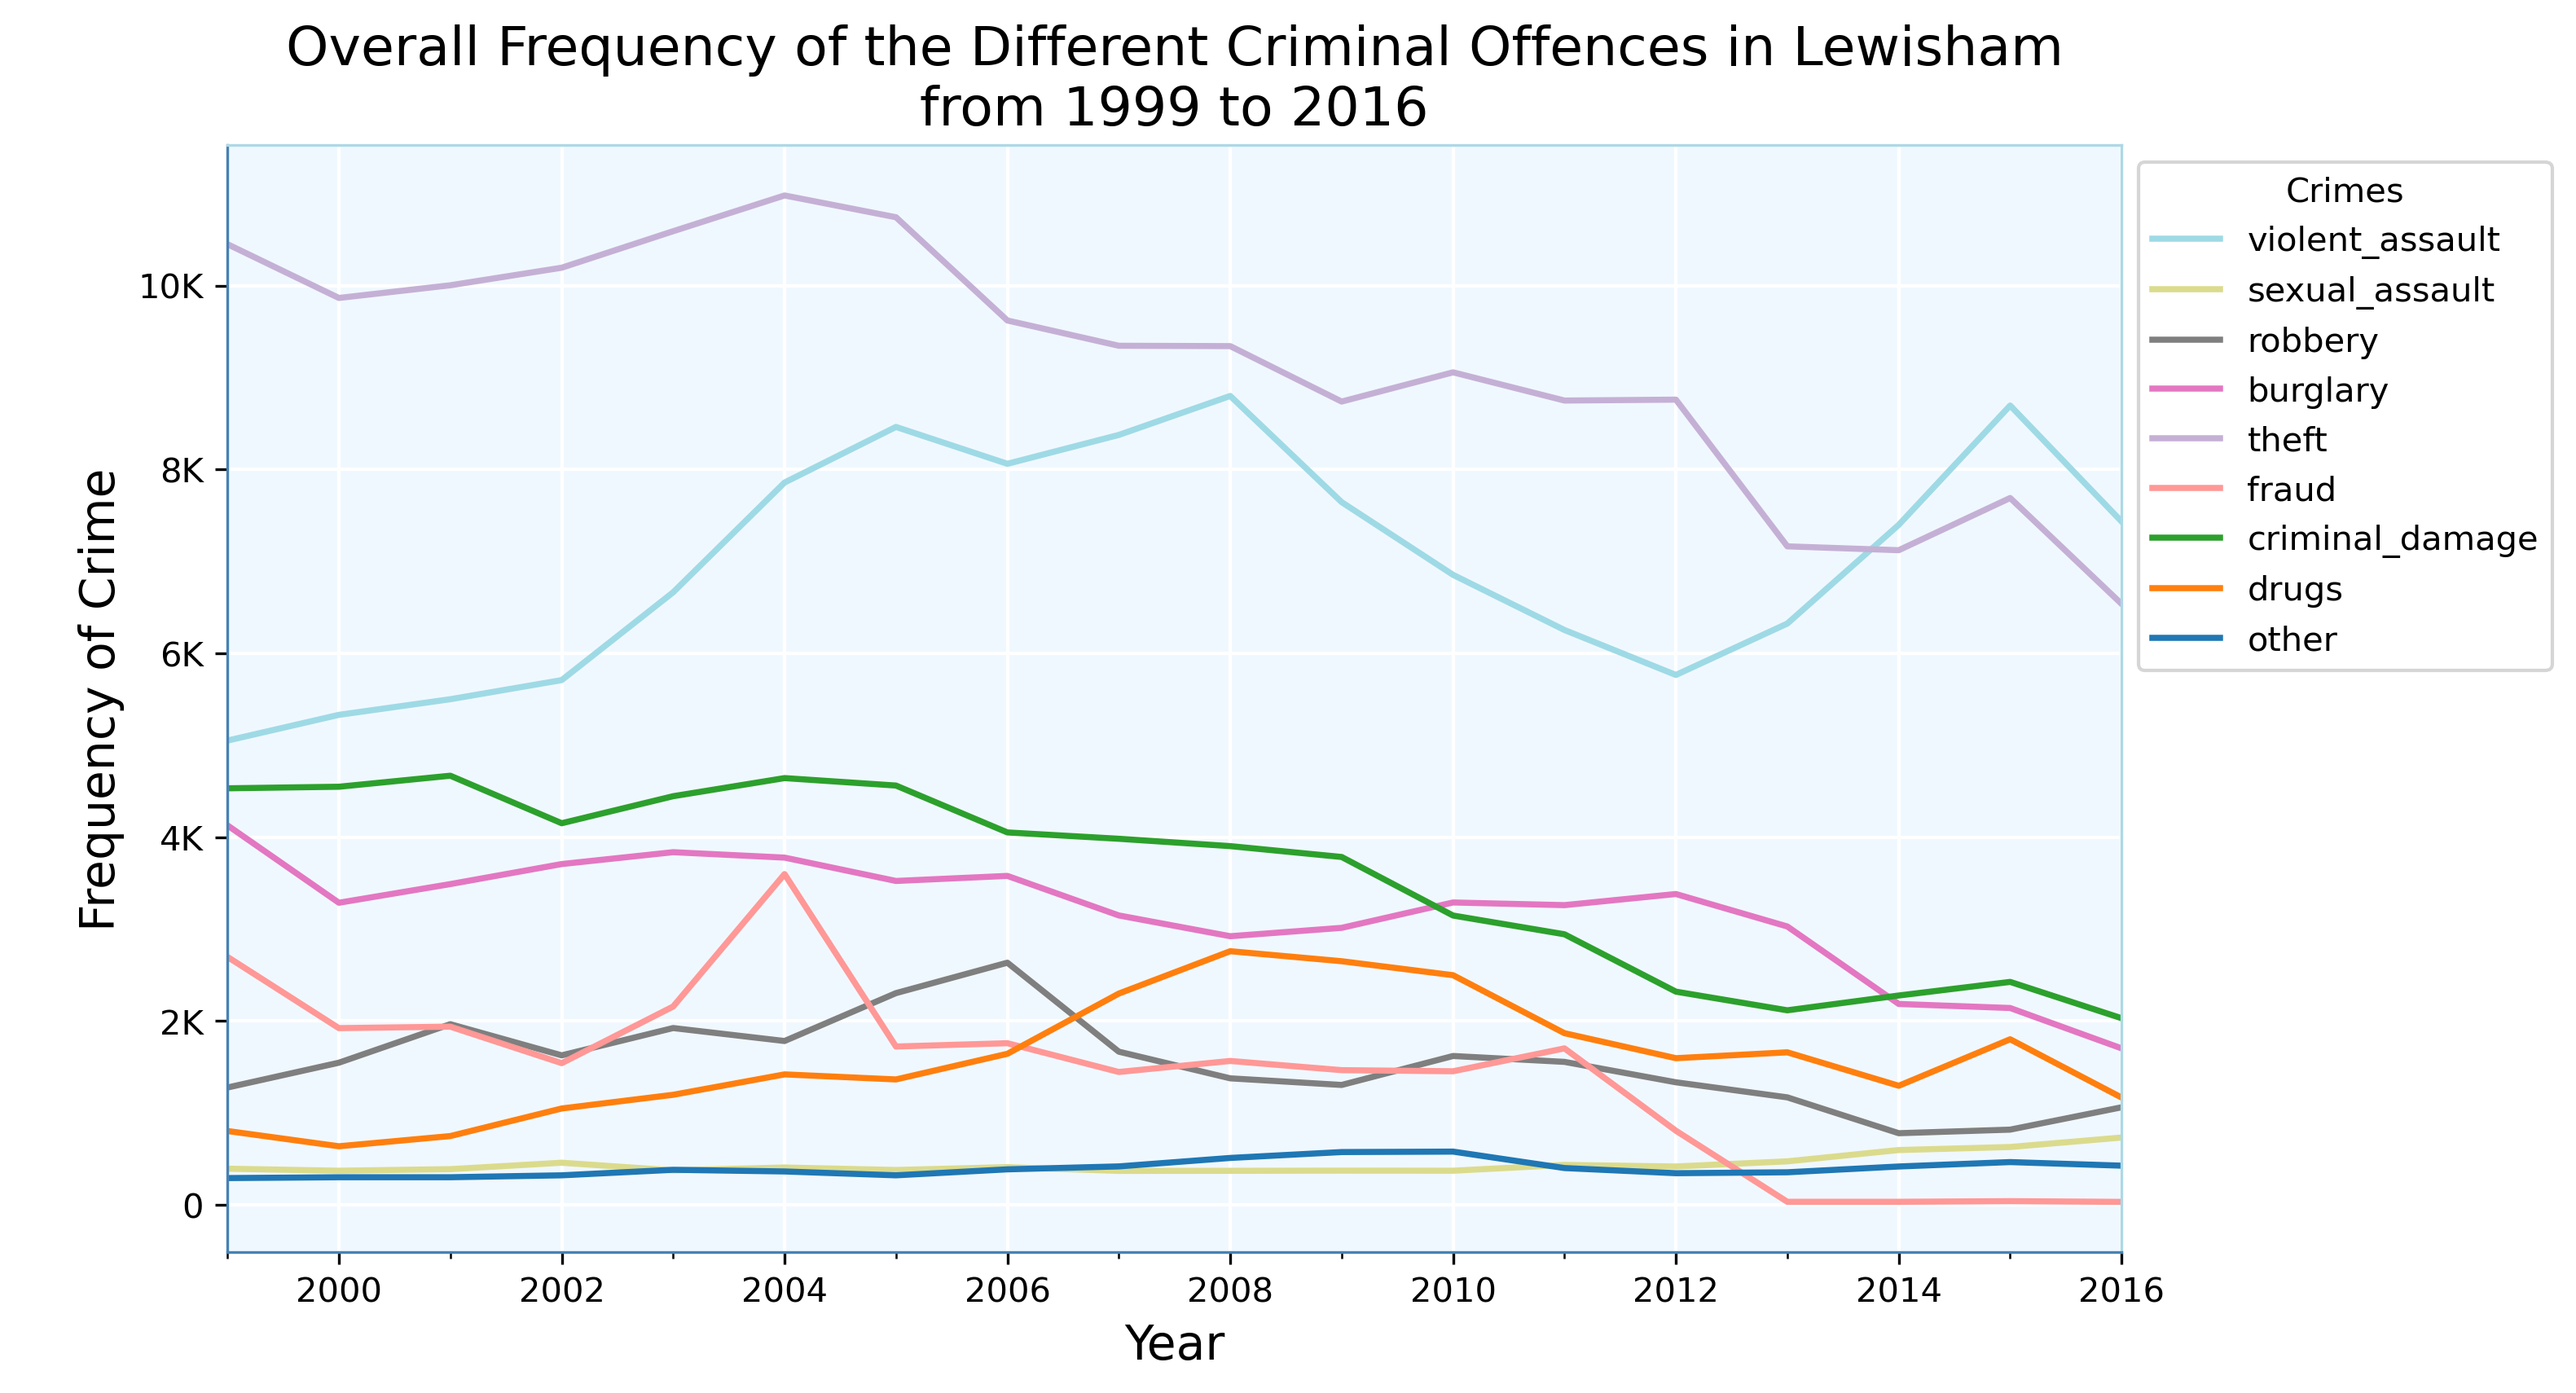

In [576]:
ax = lewisham.plot(grid=True, colormap='tab20_r', figsize = (10,6), linewidth = 1.8, zorder=2.5)
colours(1)
ax.grid(color='white', linewidth=1.0)
ax.legend( title='Crimes', bbox_to_anchor = (1.0, 1.0))
ax_title_xy(ax, 'Overall Frequency of the Different Criminal Offences in Lewisham\nfrom 1999 to 2016',
           'Year','\nFrequency of Crime')

ytick_k(ax,0)# change y ticks to add k
plt.savefig('export/lewisham_all_crime_time.png', bbox_inches='tight',facecolor='aliceblue', dpi = 350)
plt.show()

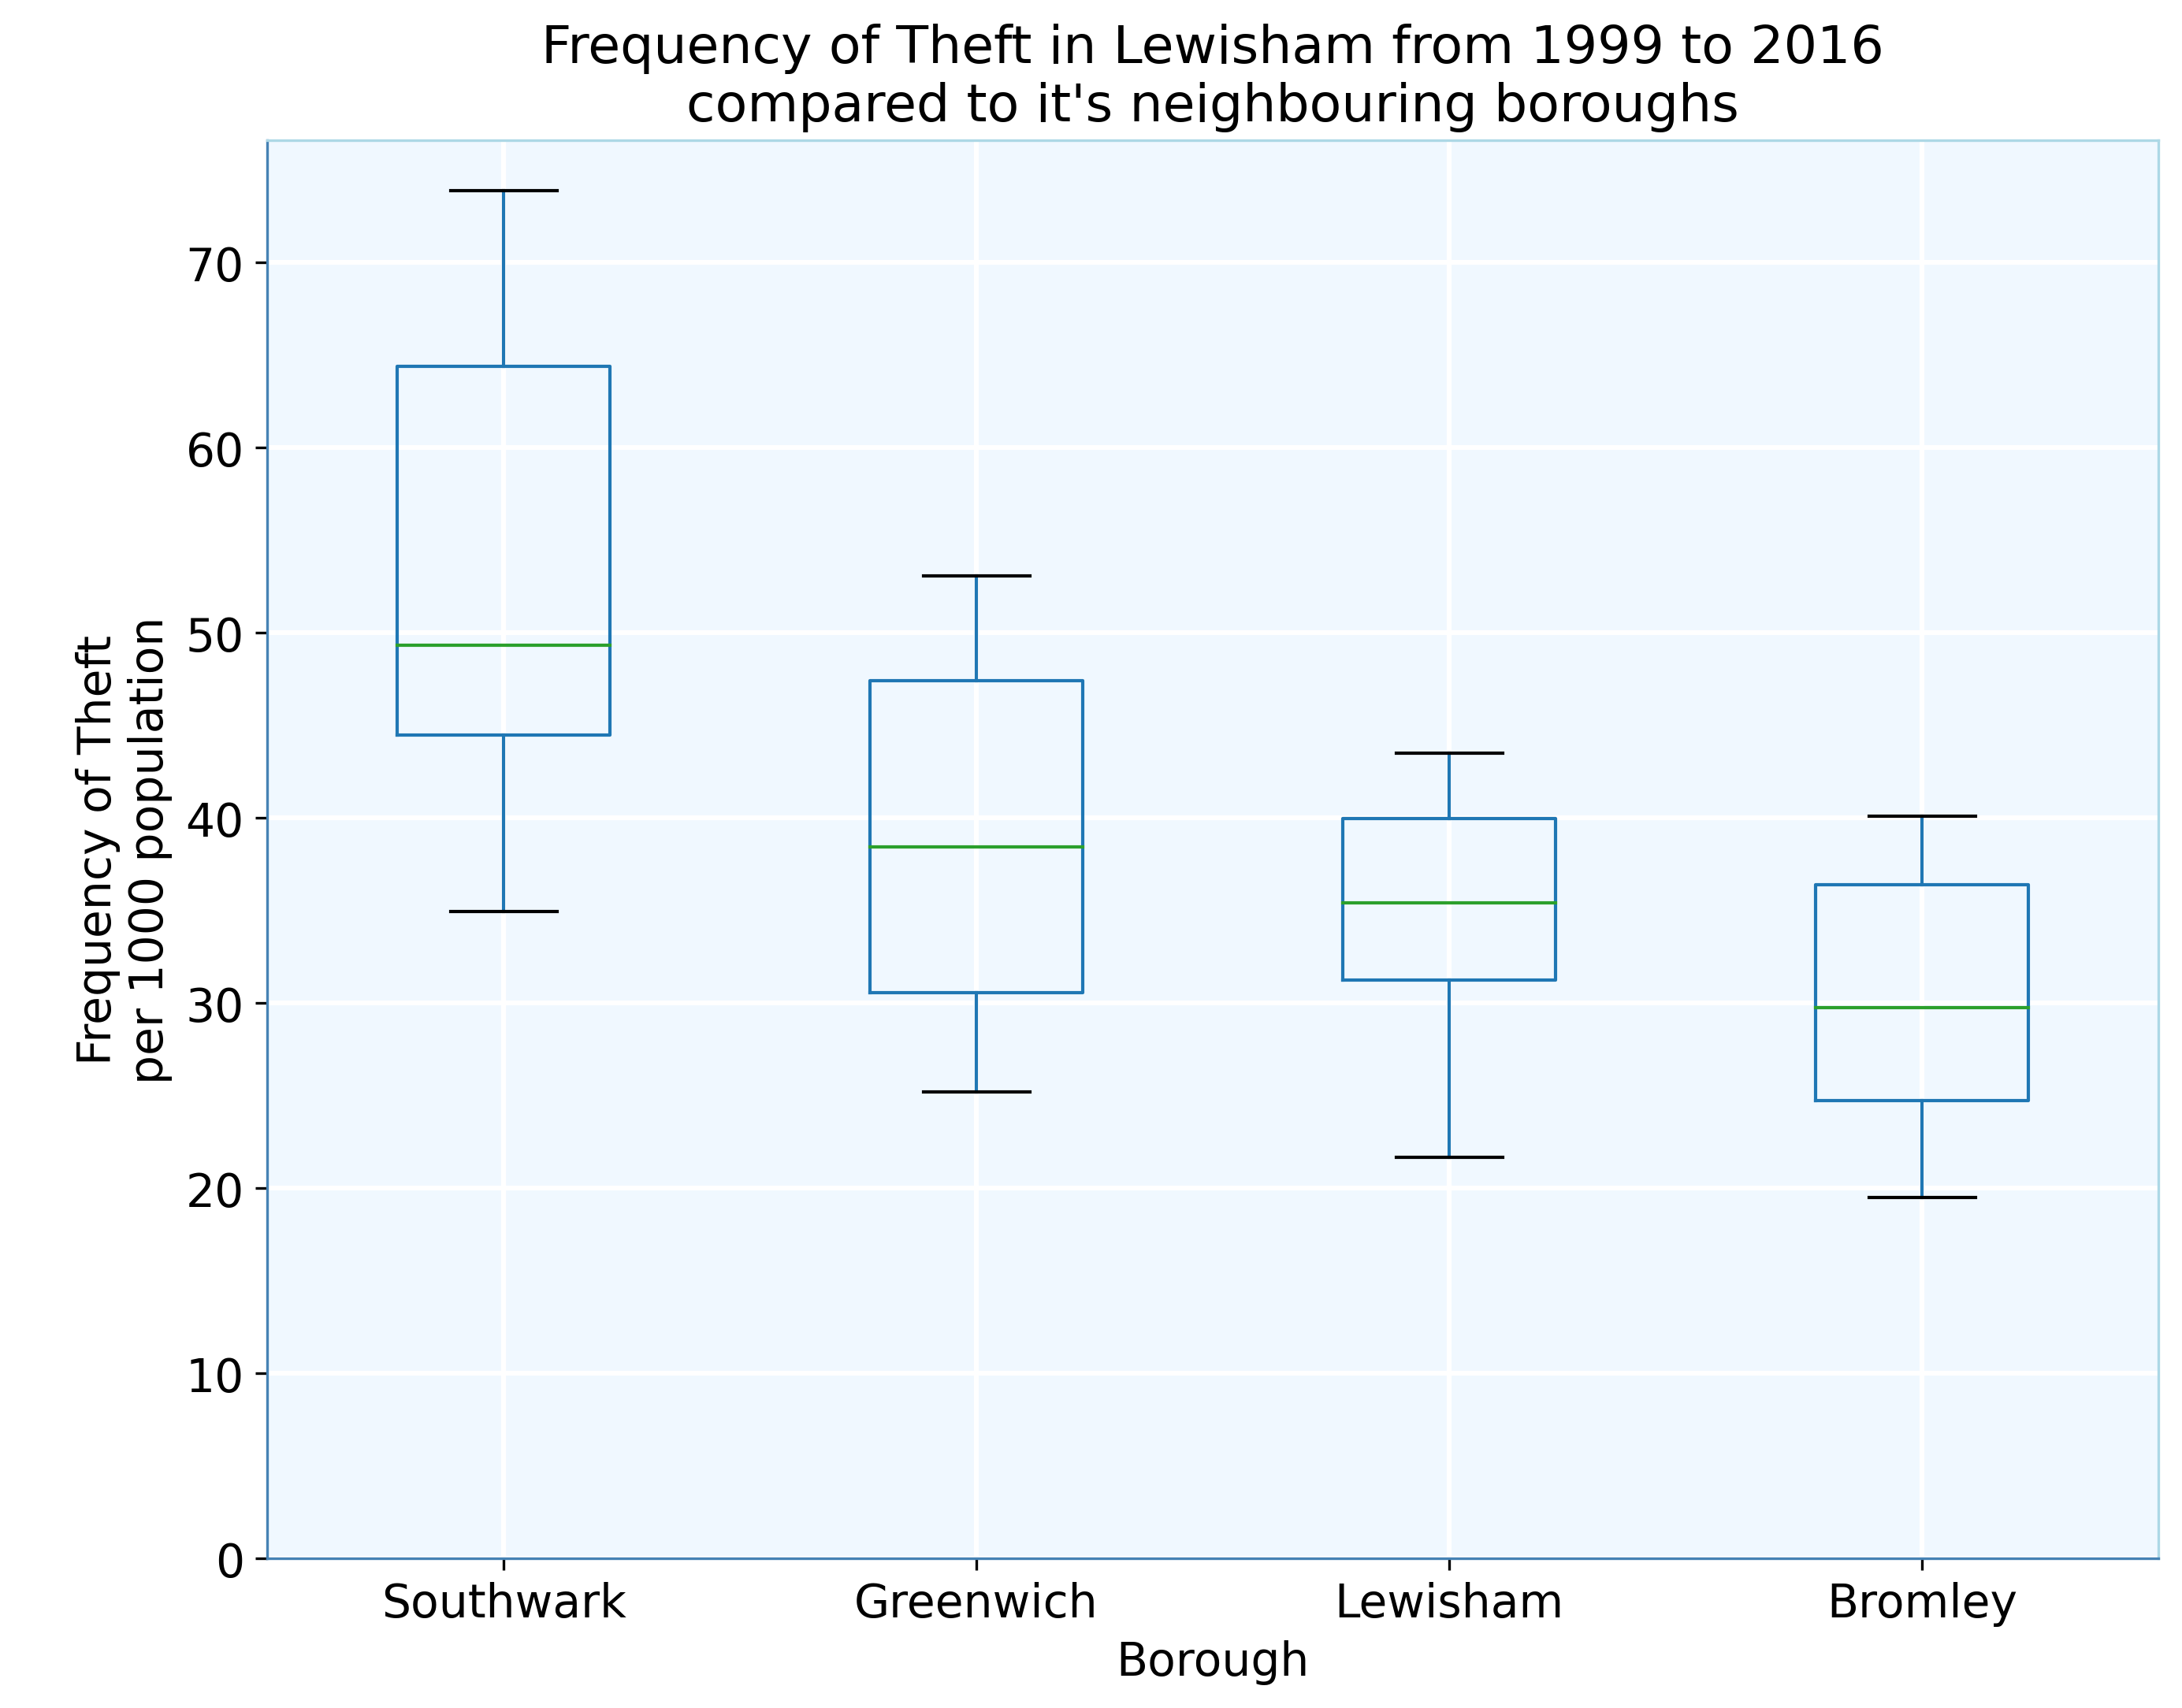

In [624]:
def rowRange(num): 
    return np.arange(0,num,1)# takes inpur and returns array 

#bromley, southwark, greenwich
br_theft = allOffences(0,rowRange(7), 'B,CO:DF', 'theft')
sw_theft = allOffences(0,rowRange(29), 'B,CO:DF', 'theft')
gw_theft = allOffences(0,rowRange(12), 'B,CO:DF', 'theft')
lh_theft = allOffences(0,rowRange(24), 'B,CO:DF','theft')
#theft originally containing theft in Lewisham
#theft.boxplot(by='borough')
df_conc = pd.concat([lh_theft, gw_theft, sw_theft,br_theft],axis=0)
median_value = df_conc.groupby('Borough').median().sort_values(
                            by='theft', ascending=False)
df_conc['Borough'] = df_conc['Borough'].astype(pd.CategoricalDtype(median_value.index, ordered=True))

ax = df_conc.boxplot(by='Borough',fontsize=14, figsize = (10,8))

ax_title_xy(ax, 
             'Frequency of Theft in Lewisham from 1999 to 2016\ncompared to it\'s neighbouring boroughs',
             'Borough',
             '\nFrequency of Theft\nper 1000 population'
            )

plt.suptitle('')
ax.set_ylim(0)
#ytick_k(ax, 1)
ax.grid(color='white', linewidth=1.5)
colours(1)# change colours for everthing
plt.savefig('export/group1_boxplot.png',bbox_inches='tight',facecolor='aliceblue', dpi = 350)
plt.show()


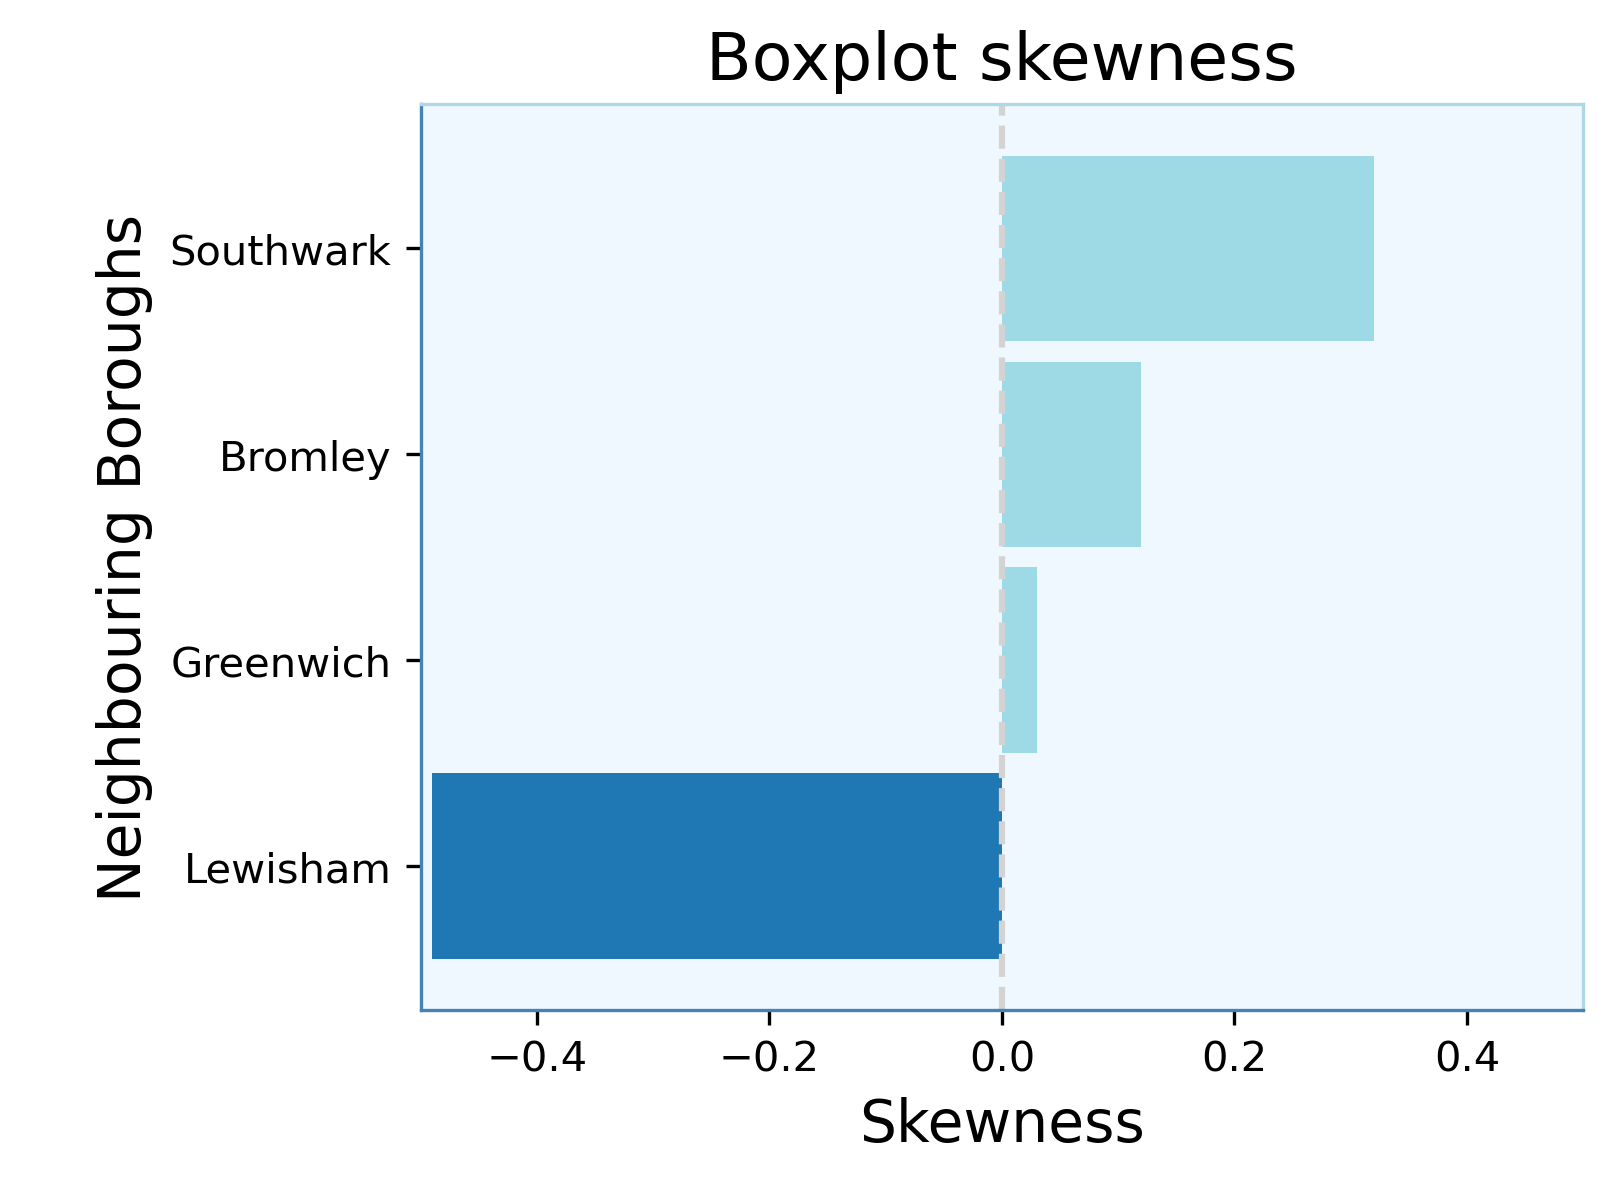

In [632]:
# calculate skews
lh_skew = lh_theft['theft'].skew().round(2)
sw_skew = sw_theft['theft'].skew().round(2)
gw_skew = gw_theft['theft'].skew().round(2)
br_skew = br_theft['theft'].skew().round(2)

col = ['Lewisham', 'Greenwich', 'Bromley', 'Southwark']
# store skews in df
skew = pd.DataFrame(np.array([[lh_skew, gw_skew, br_skew, sw_skew]]),
                   columns=col)
skew_m = skew.melt(var_name='Borough', value_name='skew')
#plot skews df horizontally
ax = skew_m.plot.barh(width=0.9, 
                     colormap='tab20_r', 
                     legend=False,
                     figsize=(5,4))
# set ticks
ax.set_yticklabels(col)
# make it centered
ax.set_xlim(-0.5,0.5)
ax_title_xy(ax, 'Boxplot skewness', 'Skewness','\nNeighbouring Boroughs', )
ax.axvline(0, linestyle='--', color='lightgrey')
ax.patches[0].set_facecolor('tab:blue')
colours(1)
#plt.savefig('export/group1_skew.png',bbox_inches='tight',facecolor='aliceblue', dpi = 350)
plt.show()


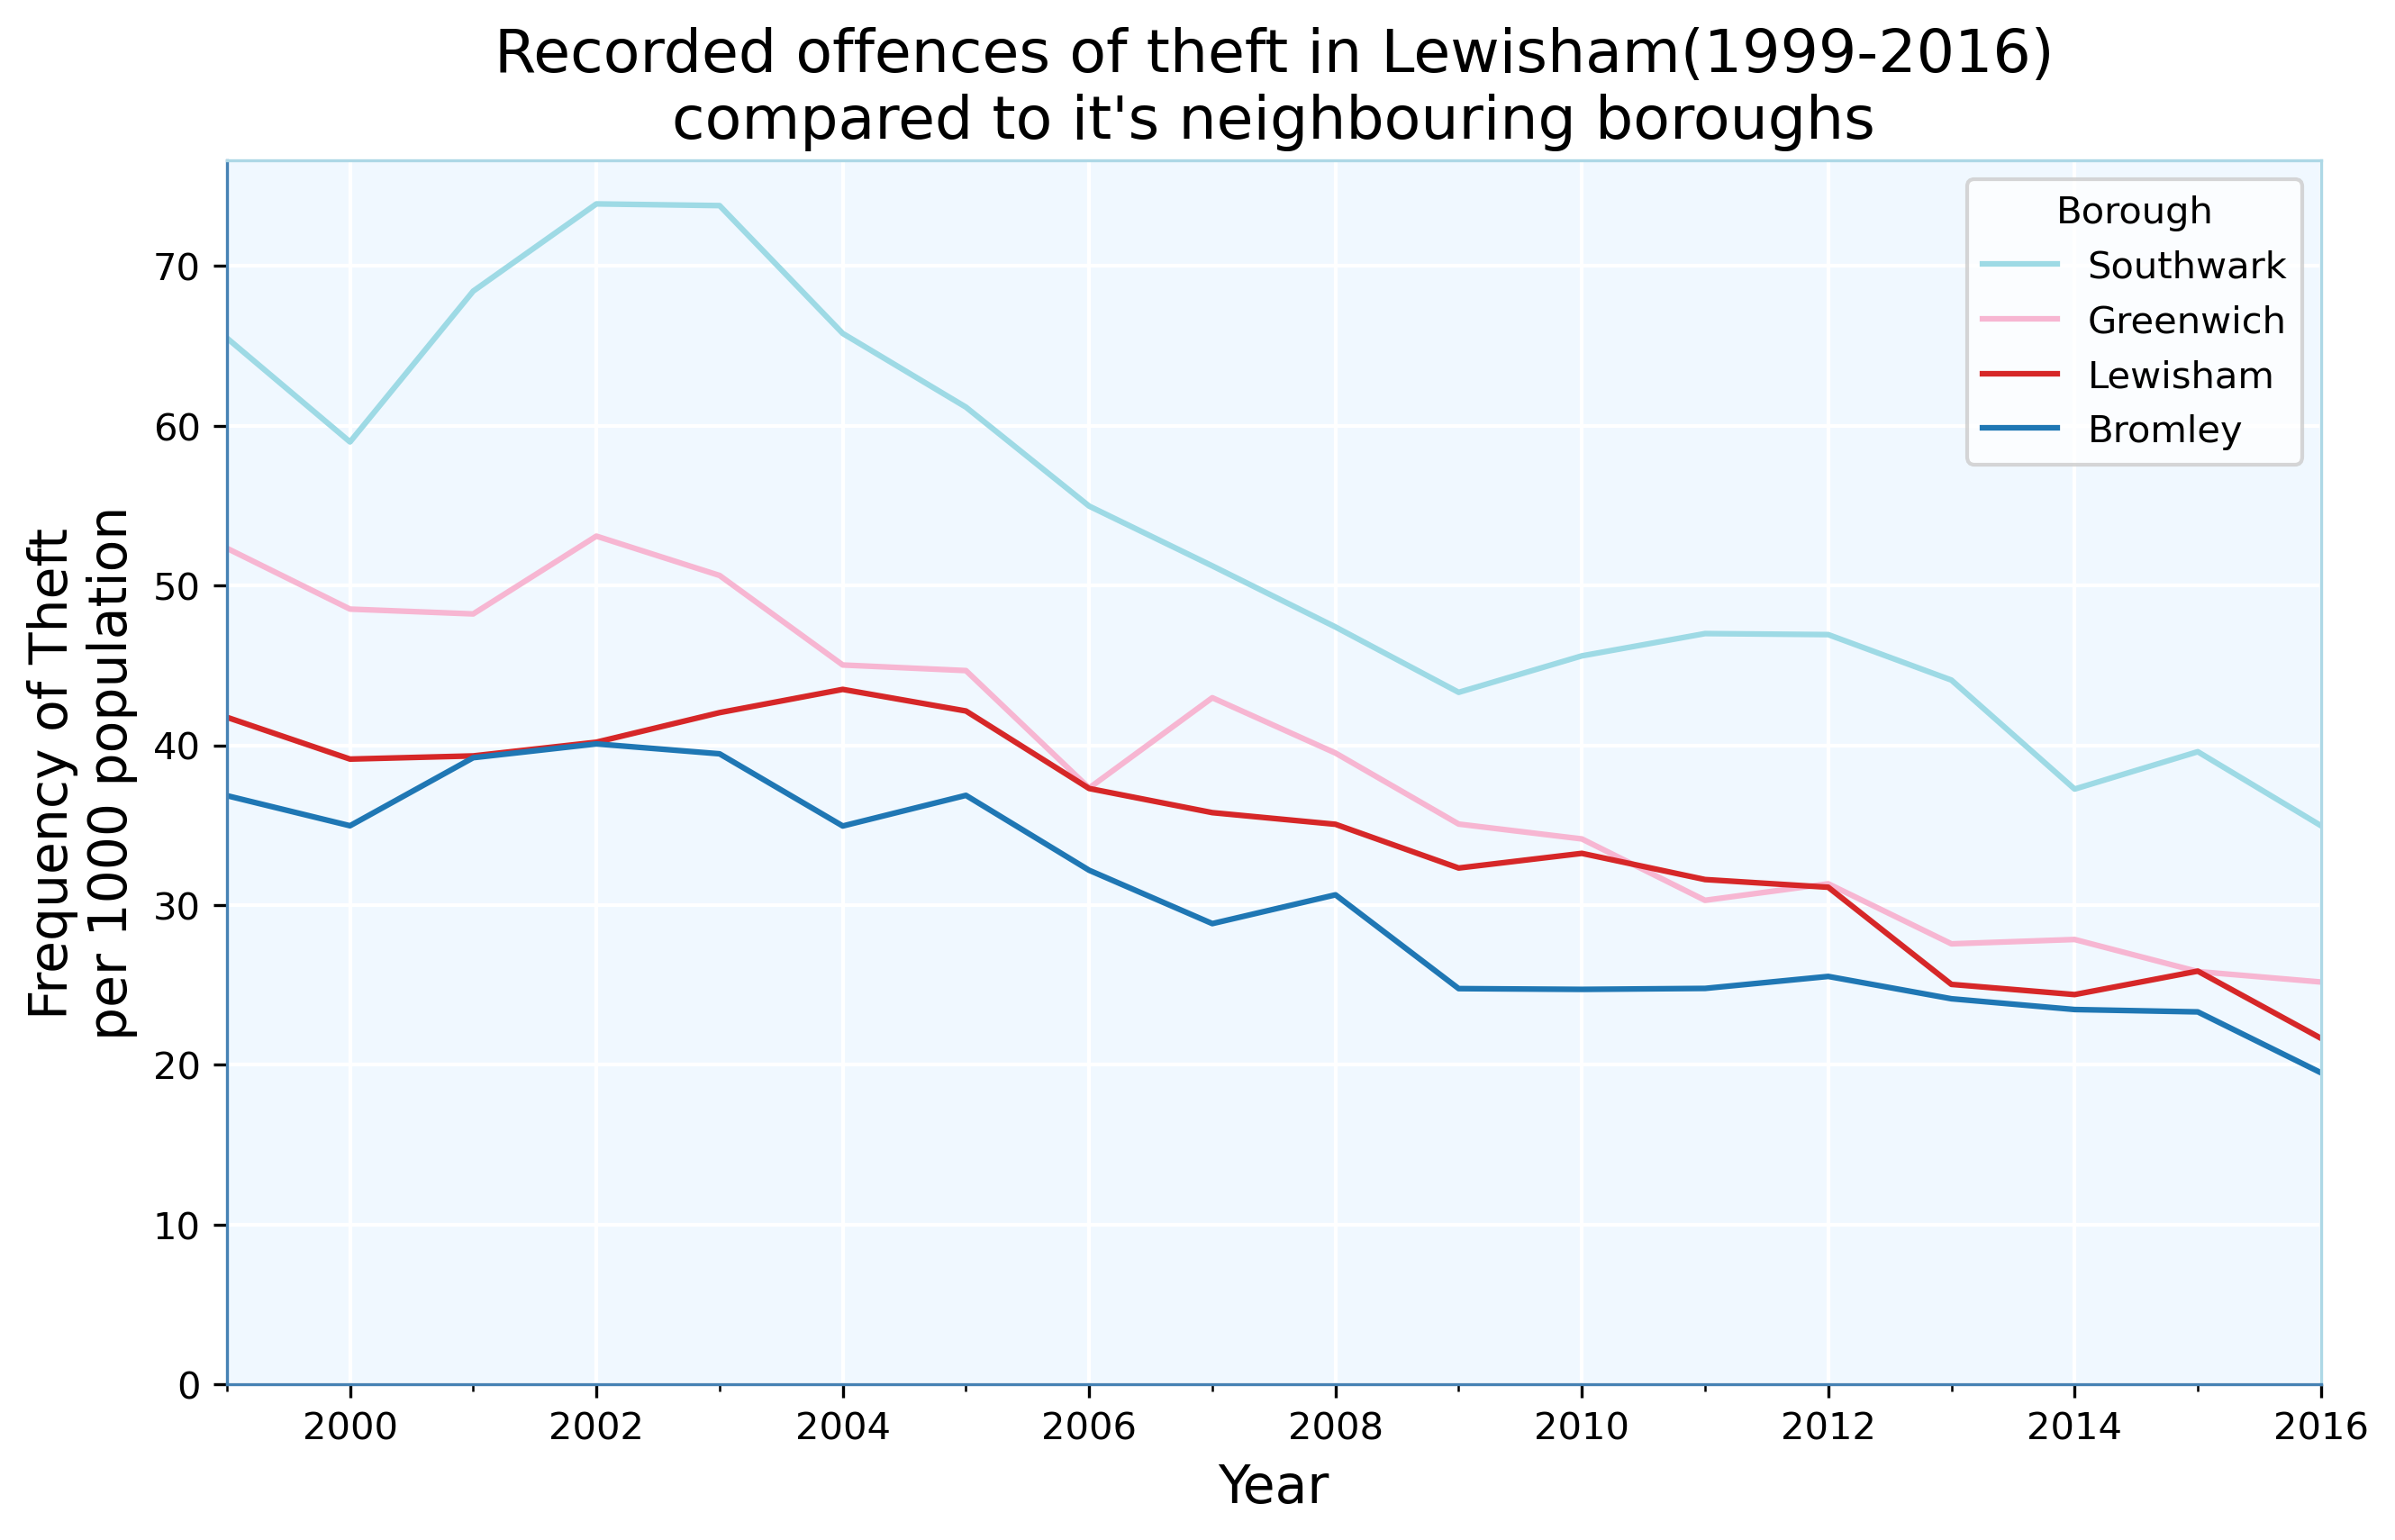

In [622]:
# time series
df2 = df_conc.copy()
df2 = df2.reset_index(level='year')
df2 = df2.pivot(index='year', values = 'theft',columns='Borough')
ax = df2.plot(colormap='tab20_r',figsize = (10,6))
ax.grid(color='white', linewidth=1.0)
ax.set_ylim(0)

ax_title_xy(ax,'Recorded offences of theft in Lewisham(1999-2016)\ncompared to it\'s neighbouring boroughs',
            'Year','Frequency of Theft\nper 1000 population')

colours(1)
plt.savefig('export/group1_theft_time.png',bbox_inches='tight',facecolor='aliceblue', dpi = 350)
plt.show()


Lambeth, Hackney, Newham and Tower Hamlets.

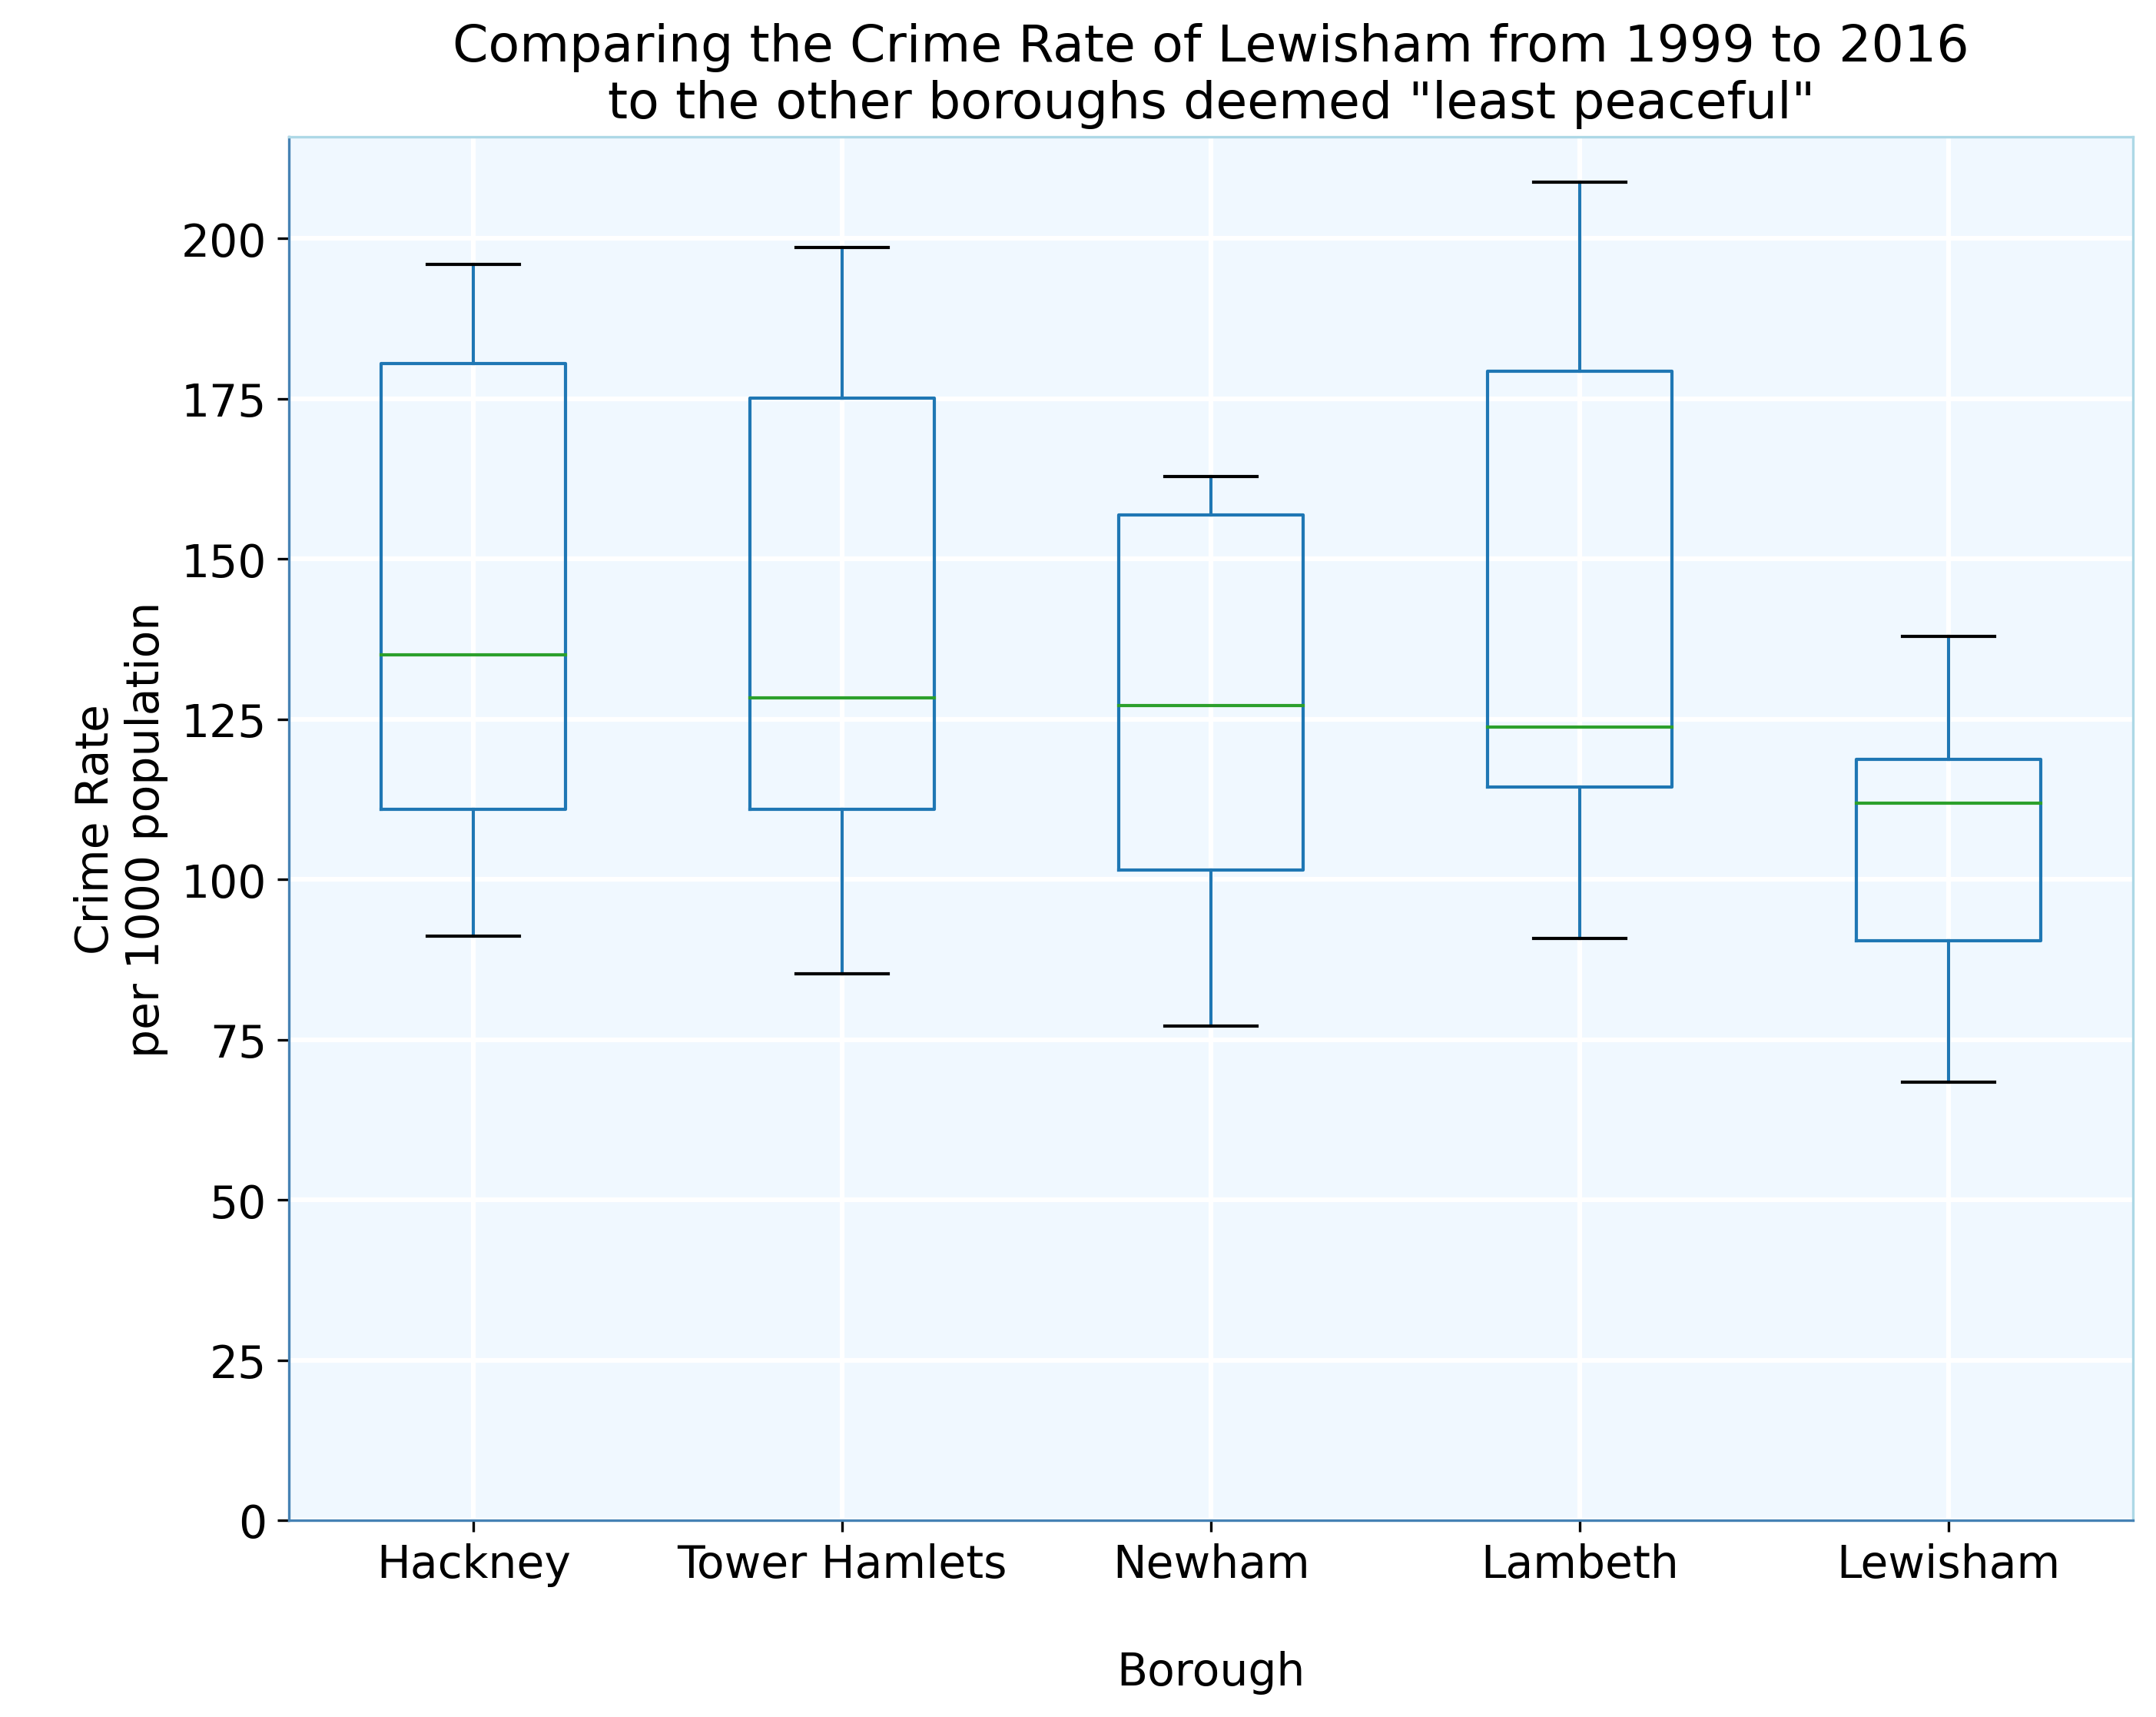

In [620]:
def rowRange(num): 
    return np.arange(0,num,1)
cols= 'B:T'
# plotting and comparing Lewisham, Lambeth, Hackney, Newham and Tower Hamlets.
lewisham= allOffences(0,rowRange(24), cols, 'crime_rate')
lambeth = allOffences(0,rowRange(23), cols, 'crime_rate')
hackney = allOffences(0,rowRange(13), cols, 'crime_rate')
newham  = allOffences(0,rowRange(26), cols, 'crime_rate')
tower_h = allOffences(0,rowRange(31), cols, 'crime_rate')

# joining up seperate dfs
df2_conc = pd.concat([lewisham, lambeth, hackney,newham, tower_h],axis=0)
median_value = df2_conc.groupby('Borough').median().sort_values(
                            by='crime_rate', ascending=False)
df2_conc['Borough'] = df2_conc['Borough'].astype(pd.CategoricalDtype(median_value.index, ordered=True))

ax = df2_conc.boxplot(by='Borough',fontsize=14, figsize = (10,8))
# title
ax_title_xy(ax, 
             'Comparing the Crime Rate of Lewisham from 1999 to 2016\nto the other boroughs deemed \"least peaceful\"',
             '\nBorough',
             '\nCrime Rate\nper 1000 population'
            )

plt.suptitle('')
ax.set_ylim(0)
#ytick_k(ax, 1)
ax.grid(color='white', linewidth=1.5)
colours(1)

#plt.savefig('export/group2_boxplot.png',bbox_inches='tight',facecolor='aliceblue', dpi = 350)
plt.show()


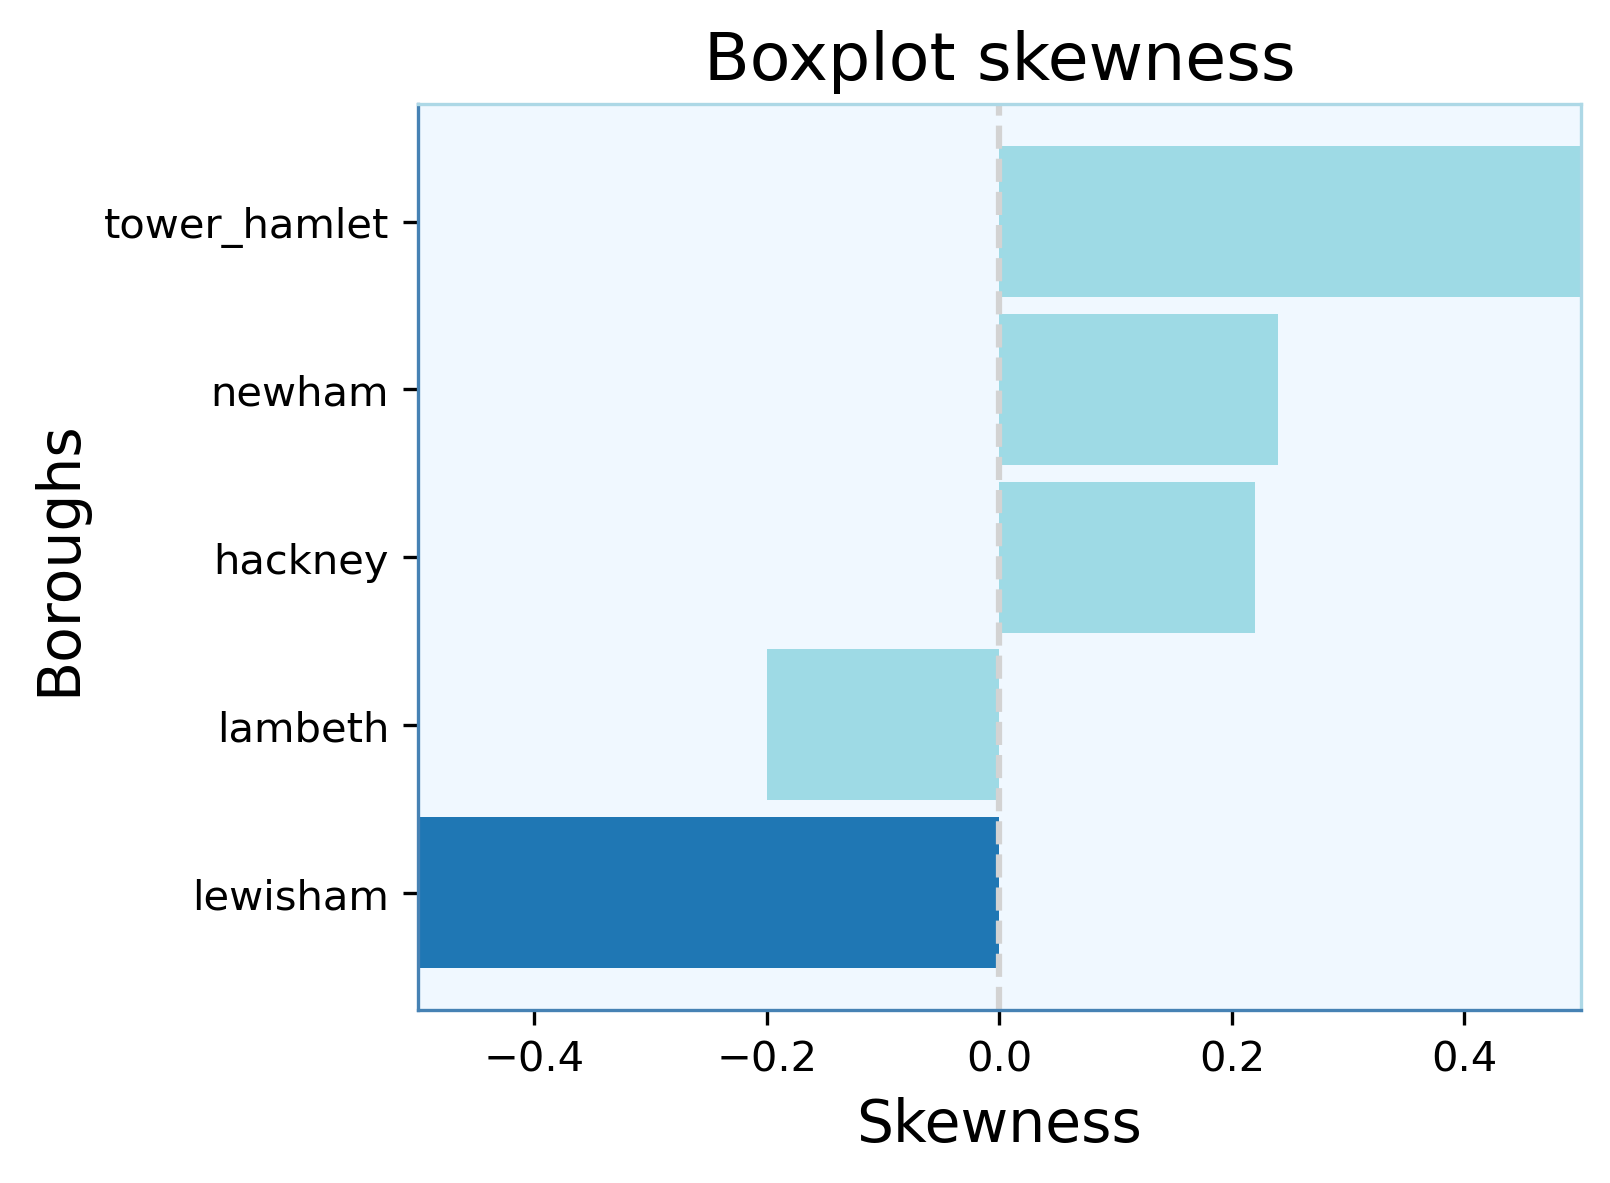

In [633]:
#skew plot
skew_lewisham = lewisham['crime_rate'].skew().round(2)
skew_lambeth = lambeth['crime_rate'].skew().round(2)
skew_hackney = hackney['crime_rate'].skew().round(2)
skew_newham = newham['crime_rate'].skew().round(2)
skew_tower_h = tower_h['crime_rate'].skew().round(2)

col = ['lewisham', 'lambeth', 'hackney', 'newham','tower_hamlet']
skew_rate = pd.DataFrame(np.array([[skew_lewisham, skew_lambeth, skew_hackney, skew_newham,skew_tower_h]]),
                   columns=col)
skew_rate_m = skew_rate.melt(var_name='Borough', value_name='skew')

ax = skew_rate_m.sort_values(by='skew').plot.barh(width=0.9, 
                     colormap='tab20_r', 
                     legend=False,
                     figsize=(5,4))
ax.set_yticklabels(col)
ax.set_xlim(-0.5,0.5)
ax_title_xy(ax, 'Boxplot skewness', 'Skewness','Boroughs', )
ax.axvline(0, linestyle='--', color='lightgrey')
ax.patches[0].set_facecolor('tab:blue')
colours(1)
plt.savefig('export/group2_skew.png',bbox_inches='tight',facecolor='aliceblue', dpi = 350)
plt.show()

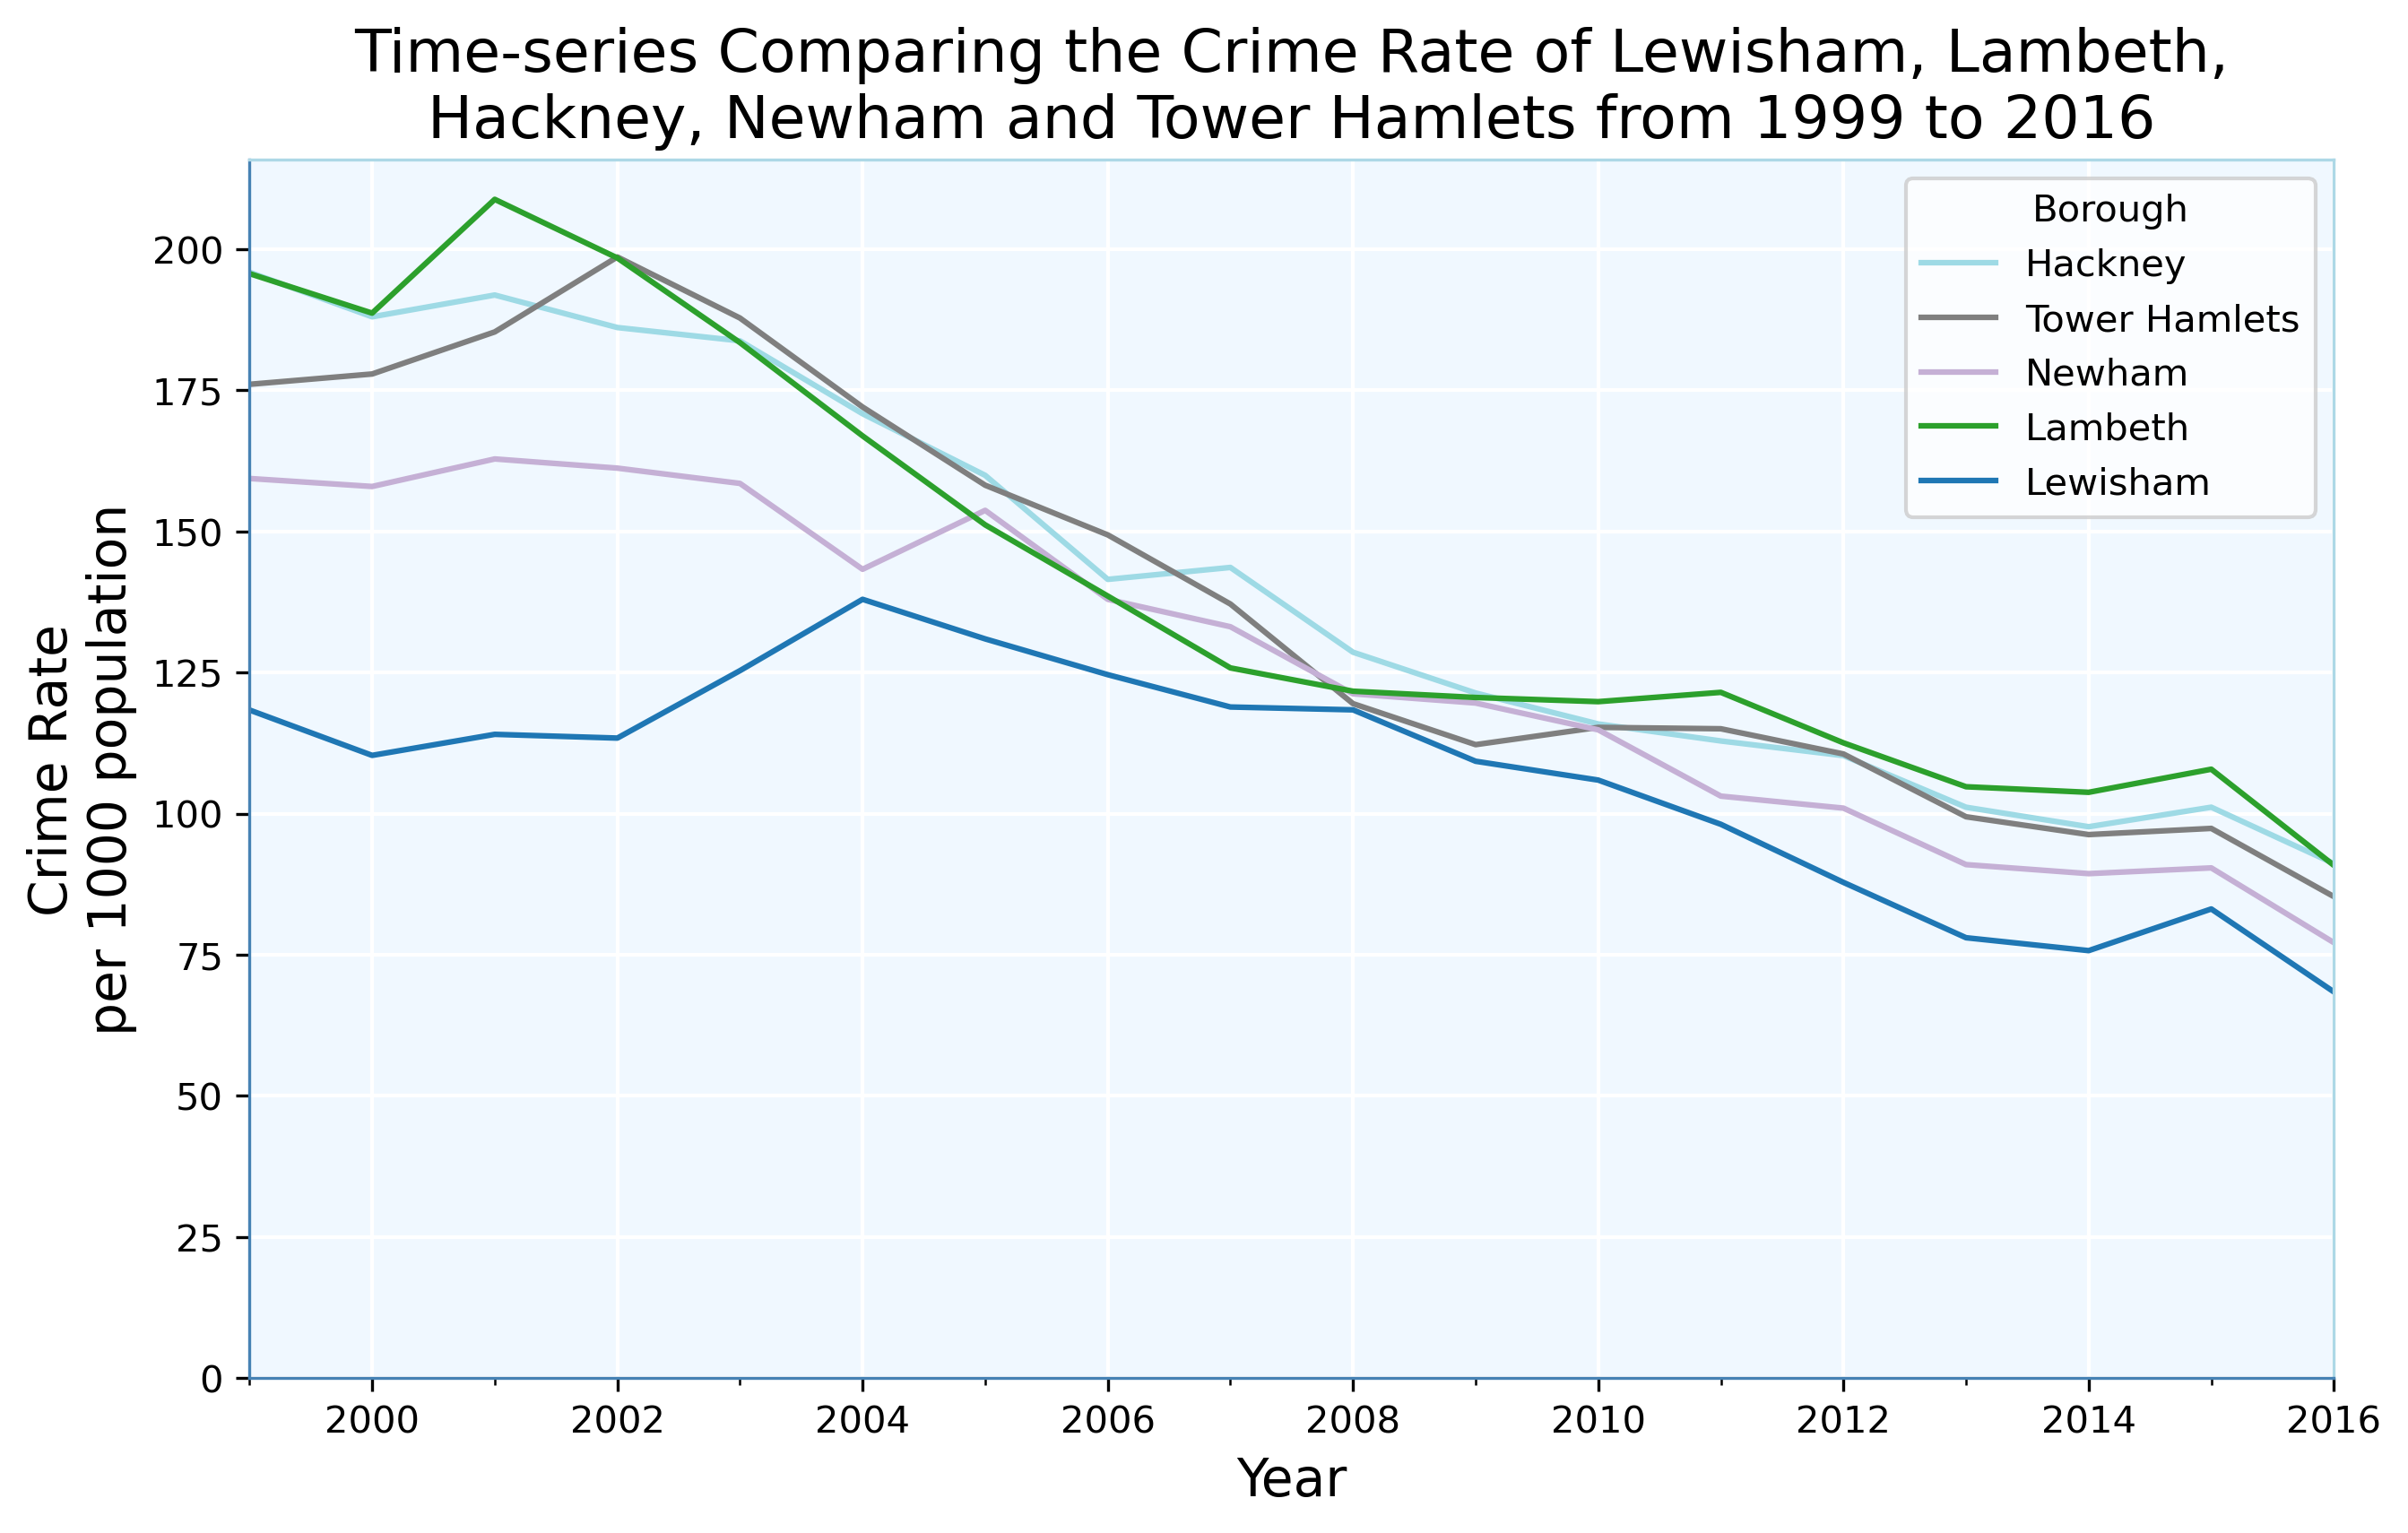

In [619]:
df3 = df2_conc.copy()
df3 = df3.reset_index(level='year')
df3 = df3.pivot(index='year', values = 'crime_rate',columns='Borough')
ax = df3.plot(colormap='tab20_r',figsize = (10,6))
ax.grid(color='white', linewidth=1.0)
ax.set_ylim(0)
ax_title_xy(ax,'Time-series Comparing the Crime Rate of Lewisham, Lambeth,\nHackney, Newham and Tower Hamlets from 1999 to 2016',
            'Year','Crime Rate\nper 1000 population')

colours(1)
plt.savefig('export/group2_crimerate_time.png',bbox_inches='tight',facecolor='aliceblue', dpi = 350)
plt.show()



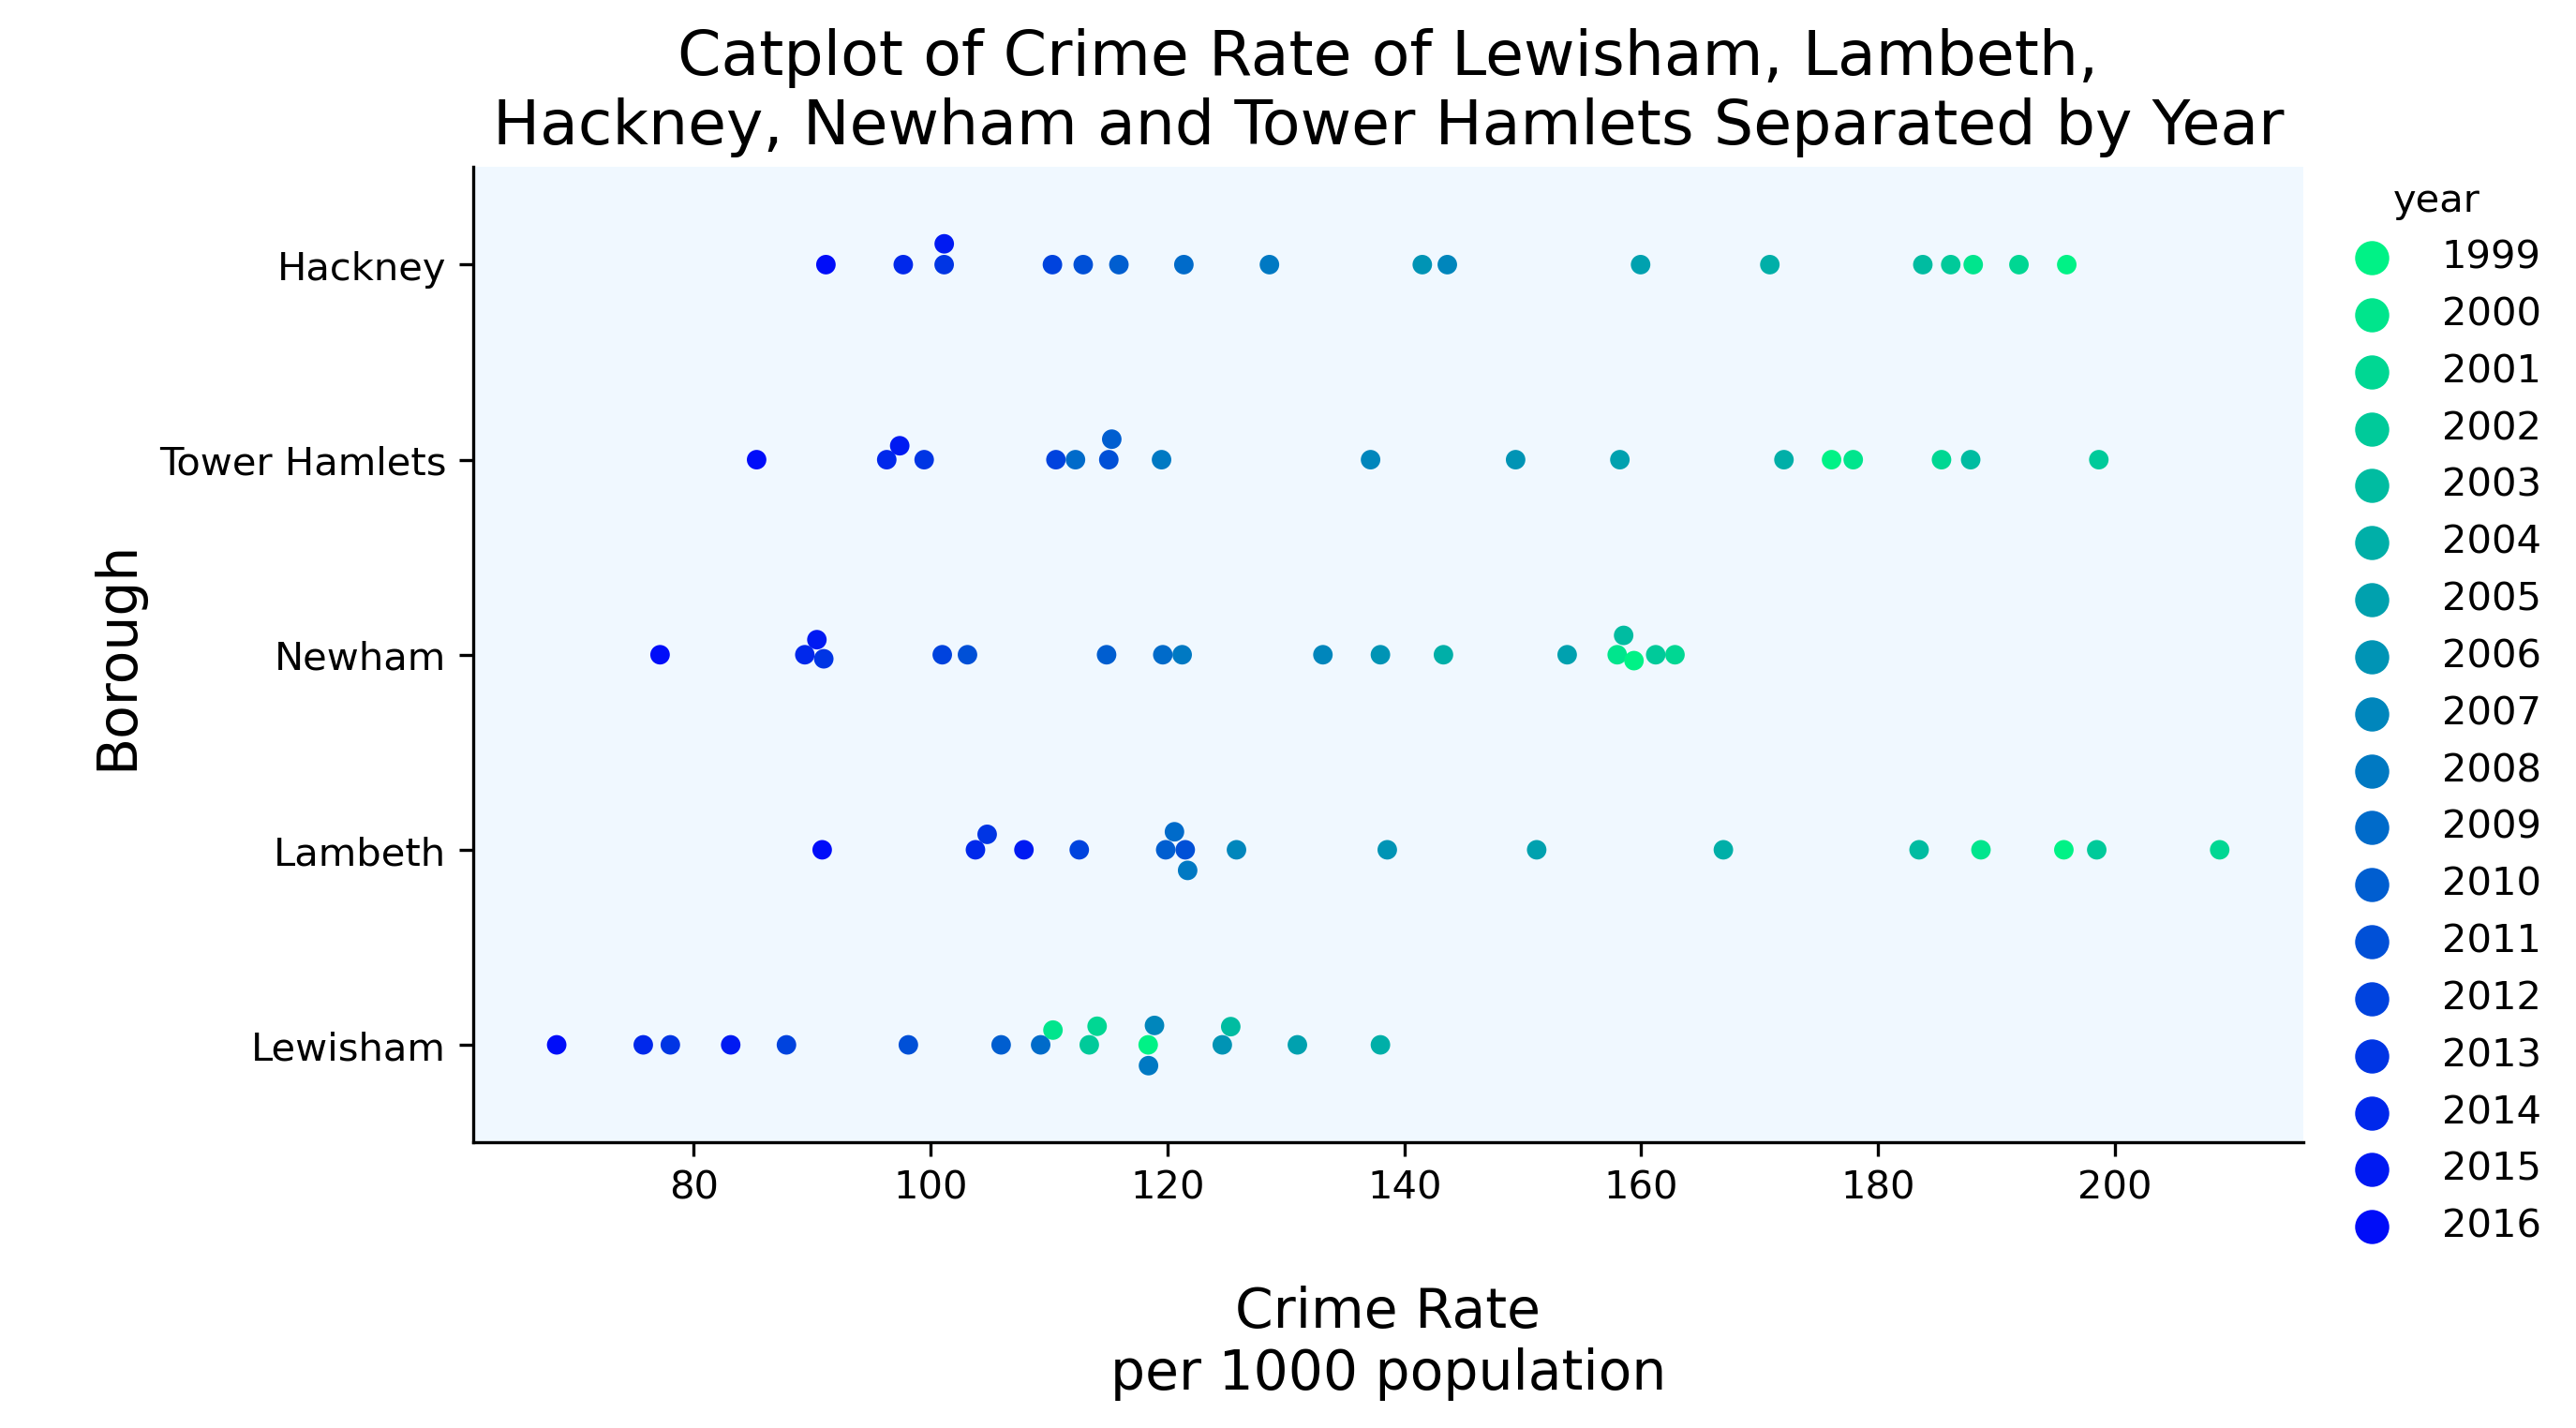

In [621]:
df_catplot = df2_conc.copy()
df_catplot = df_catplot.reset_index(level='year')
median_value = df_catplot.groupby('Borough').median().sort_values(
                            by='crime_rate', ascending=False)
df_catplot['Borough'] = df_catplot['Borough'].astype(pd.CategoricalDtype(median_value.index, ordered=True))


plot = sb.catplot(x='crime_rate', y='Borough', 
                  hue='year', data=df_catplot, 
                  kind="swarm", palette='winter_r',
                 height=4, aspect=2)
ax_title_xy(plot.ax, 
             'Catplot of Crime Rate of Lewisham, Lambeth,\nHackney, Newham and Tower Hamlets Separated by Year',
             '\nCrime Rate\nper 1000 population','\nBorough'
            )
plot.ax.set_facecolor('aliceblue')
plt.savefig('export/group2_catplot.png',bbox_inches='tight',facecolor='aliceblue', dpi = 350)
plt.show()